# Intuit Quickbooks Upgrade


In [2]:
import pandas as pd
import pyrsm as rsm
from utils import functions

In [3]:
## loading the data - this dataset must NOT be changed
intuit75k = pd.read_parquet("data/intuit75k.parquet")
intuit75k.head()

,id,zip5,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,res1,training,res1_yes
0,1,94553,18,Male,0,2,109.5,5,12,0,0,0,No,1,0
1,2,53190,10,Unknown,0,1,69.5,4,3,0,0,0,No,0,0
2,3,37091,8,Male,0,4,93.0,14,29,0,0,1,No,0,0
3,4,02125,1,Male,0,1,22.0,17,1,0,0,0,No,1,0
4,5,60201,11,Male,0,1,24.5,2,3,0,0,0,No,0,0


In [4]:
rsm.md("data/intuit75k_description.md")


## Intuit: Quickbooks upgrade

The purpose of this exercise is to gain experience modeling the response to an upsell campaign. The `intuit75k.parquet` file contains data on 75,000 (small) businesses that were selected randomly from the 801,821 that were sent the wave-1 mailing. The mailing contained an offer to upgrade to the latest version of the Quickbooks software.

Variable `res1` denotes which of these businesses responded to the mailing by purchasing Quickbooks version 3.0 from "Intuit Direct". Note that Intuit Direct sells products directly to its customers rather than through a retailer. Use the available data to predict which businesses that did not respond to the wave-1 mailing, are most likely to respond to the wave-2 mailing. Note that variables were added, deleted, and recoded so please ignore the variable descriptions in Exhibit 3 in the case pdf. Instead, use the variable descriptions below:

## Variable description

* id: Small business customer ID
* zip5: 5-Digit ZIP Code (00000=unknown, 99999=international ZIPs).
* zip_bins: Zip-code bins (20 approx. equal sized bins from lowest to highest zip code number)
* sex: Gender Identity "Female", "Male", or "Unknown"
* bizflag: Business Flag. Address contains a Business name (1 = yes, 0 = no or unknown).
* numords: Number of orders from Intuit Direct in the previous 36 months
* dollars: Total $ ordered from Intuit Direct in the previous 36 months
* last: Time (in months) since last order from Intuit Direct in previous 36 months
* sincepurch: Time (in months) since original (not upgrade) purchase of Quickbooks
* version1: Is 1 if customer's current Quickbooks is version 1, 0 if version 2
* owntaxprod: Is 1 if customer purchased tax software, 0 otherwise
* upgraded: Is 1 if customer upgraded from Quickbooks vs. 1 to vs. 2
* res1: Response to wave 1 mailing ("Yes" if responded else "No")
* training: 70/30 split, 1 for training sample, 0 for test sample

In [5]:
intuit75k.head()

,id,zip5,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,res1,training,res1_yes
0,1,94553,18,Male,0,2,109.5,5,12,0,0,0,No,1,0
1,2,53190,10,Unknown,0,1,69.5,4,3,0,0,0,No,0,0
2,3,37091,8,Male,0,4,93.0,14,29,0,0,1,No,0,0
3,4,02125,1,Male,0,1,22.0,17,1,0,0,0,No,1,0
4,5,60201,11,Male,0,1,24.5,2,3,0,0,0,No,0,0


In [6]:
functions.example()


You just accessed a function from your first python packages!
Change the code in utils/function.py to whatever you need for this assignment
Use 'from utils import functions' to get access to your code
You can add modules to import from by adding additional .py files to the 'utils' directory
Note: If you make changes to the content of this file you will have to restart the notebook kernel to get the updates



In [7]:
# show the content of another notebook
rsm.md_notebook("./sub-notebooks/question1.ipynb")


```python
clf = rsm.model.logistic(
    data=intuit75k.query("training == 1"),
    rvar="res1",
    lev="Yes",
    evar=["numords", "version1", "upgraded"],
)
clf.summary()
```


In [8]:
# run python code from another notebook
%run ./sub-notebooks/question1.ipynb

Logistic regression (GLM)
Data                 : Not provided
Response variable    : res1
Level                : Yes
Explanatory variables: numords, version1, upgraded
Null hyp.: There is no effect of x on res1
Alt. hyp.: There is an effect of x on res1

              OR     OR%  coefficient  std.error  z.value p.value     
Intercept  0.016  -98.4%        -4.13      0.050  -81.923  < .001  ***
numords    1.352   35.2%         0.30      0.015   20.314  < .001  ***
version1   2.113  111.3%         0.75      0.051   14.634  < .001  ***
upgraded   2.628  162.8%         0.97      0.049   19.705  < .001  ***

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Pseudo R-squared (McFadden): 0.041
Pseudo R-squared (McFadden adjusted): 0.041
Area under the RO Curve (AUC): 0.659
Log-likelihood: -9630.543, AIC: 19269.086, BIC: 19304.56
Chi-squared: 828.558, df(3), p.value < 0.001 
Nr obs: 52,500


# Assignment 5

In [9]:
import numpy as np
import pandas as pd
import pyrsm as rsm
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats as sms
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn import preprocessing
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit
import matplotlib as mpl
import matplotlib.pyplot as plt

In [10]:
intuit75k.dtypes

id               int32
zip5            object
zip_bins         int32
sex           category
bizflag          int32
numords          int32
dollars        float64
last             int32
sincepurch       int32
version1         int32
owntaxprod       int32
upgraded         int32
res1          category
training         int32
res1_yes         int64
dtype: object

In [11]:
intuit75k['zip_bins'] = intuit75k['zip_bins'].astype('category')

We converted zip_bins to a categorical variable, since keeping it as an integer would impose a linear relationship between the zip code and the target variable.

In [12]:
intuit75k.isna().sum()

id            0
zip5          0
zip_bins      0
sex           0
bizflag       0
numords       0
dollars       0
last          0
sincepurch    0
version1      0
owntaxprod    0
upgraded      0
res1          0
training      0
res1_yes      0
dtype: int64

There are no missing values in the dataset, so we don't need to worry about inputting missing values.

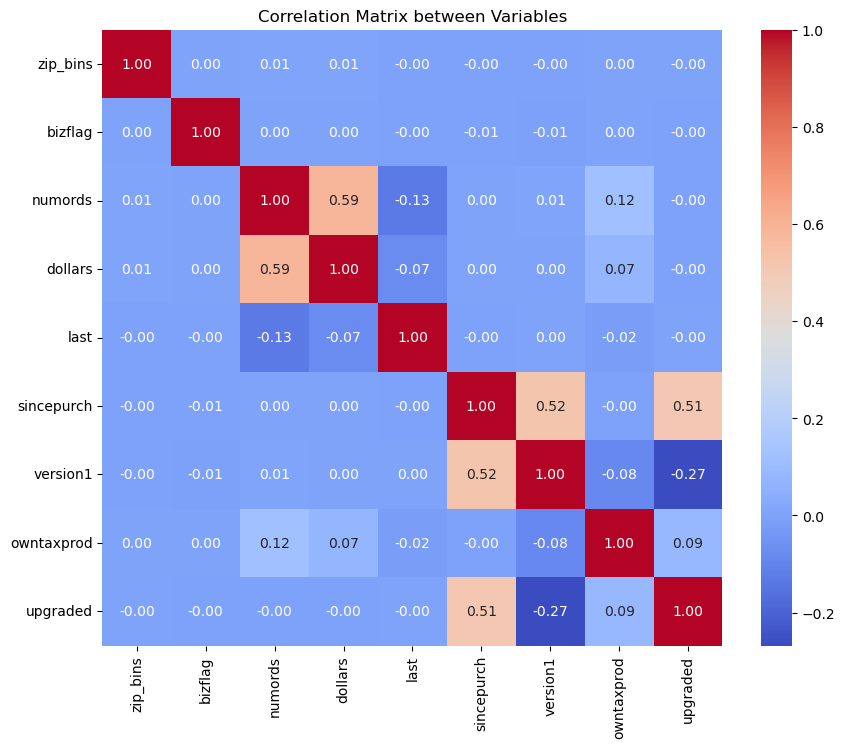

In [13]:
import seaborn as sns

# Generate a DataFrame with random data
np.random.seed(0)  # For reproducible output

# Calculate the correlation matrix
corr_matrix = intuit75k[["zip_bins", "bizflag", "numords", "dollars", "last", "sincepurch", "version1", "owntaxprod", "upgraded"]].corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix between Variables')
plt.show()

The correlation matrix highlights key relationships between variables, some of which indicate potential multicollinearity concerns. The strongest positive correlation exists between numords (number of past orders) and dollars (total spending), with a value of 0.59. This suggests that customers who order frequently tend to spend more, which is expected, but also means that these two variables may be redundant. Similarly, sincepurch (months since the first purchase) is moderately correlated with both version1 (owning QuickBooks Version 1) at 0.52 and upgraded (previous upgrades) at 0.51. These relationships indicate that customers who have not upgraded in a long time are more likely to have an older QuickBooks version. The negative correlation of -0.27 between version1 and upgraded further supports this, showing that customers who own Version 1 are less likely to have upgraded in the past.

On the other hand, variables such bizflag, and owntaxprod show weak or near-zero correlations with most other features. This suggests that these variables are largely independent and may not contribute significantly to predictive modeling. Given this, it may be beneficial to remove zip_bins and bizflag from the model to simplify it without losing critical information. Additionally, due to the high correlation between numords and dollars, as well as sincepurch and version1, feature interactions such as numords * dollars or sincepurch * upgraded should be tested to determine if they capture meaningful patterns. Reducing redundant variables and introducing meaningful interactions could improve model performance by minimizing multicollinearity while retaining predictive power.

In [14]:
intuit75k_training = intuit75k[intuit75k['training'] == 1]
intuit75k_training.head()

,id,zip5,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,res1,training,res1_yes
0,1,94553,18,Male,0,2,109.5,5,12,0,0,0,No,1,0
3,4,02125,1,Male,0,1,22.0,17,1,0,0,0,No,1,0
5,6,12309,3,Male,0,1,20.0,17,17,0,0,1,No,1,0
7,8,55122,11,Male,1,1,24.5,4,17,1,0,0,No,1,0
9,10,20036,5,Male,0,3,73.5,10,9,0,0,0,No,1,0


In [15]:
intuit75k_test = intuit75k[intuit75k['training'] == 0]
intuit75k_test.head()

,id,zip5,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,res1,training,res1_yes
1,2,53190,10,Unknown,0,1,69.5,4,3,0,0,0,No,0,0
2,3,37091,8,Male,0,4,93.0,14,29,0,0,1,No,0,0
4,5,60201,11,Male,0,1,24.5,2,3,0,0,0,No,0,0
6,7,22980,5,Male,0,1,49.5,13,36,1,0,0,No,0,0
8,9,34950,8,Male,0,1,44.5,15,4,0,0,0,No,0,0


In [16]:
intuit75k_training["res1_yes"].value_counts()
#here 1 means yes and 0 means no (respondents)

res1_yes
0    50002
1     2498
Name: count, dtype: int64

In [17]:
intuit75k_test["res1_yes"].value_counts()
#here 1 means yes and 0 means no (respondents)

res1_yes
0    21397
1     1103
Name: count, dtype: int64

In [18]:
percentage_training = (len(intuit75k_training) / len(intuit75k)) * 100
print(f"% of Training data from the total data: {percentage_training:.2f}%")

percentage_test = (len(intuit75k_test) / len(intuit75k)) * 100
print(f"% of Test data from the total data: {percentage_test:.2f}%")

#sign of a good percentage distribution

% of Training data from the total data: 70.00%
% of Test data from the total data: 30.00%


## Now, working with the Training Data (to train our model)

In [19]:
## Percentage of people who bought the version 3
training_yes_percentage = f"{(intuit75k_training['res1_yes'].value_counts()[1] / len(intuit75k_training)) * 100:.2f}%"
print(f"Percentage of people who bought the version 3 in training data: {training_yes_percentage}")

Percentage of people who bought the version 3 in training data: 4.76%


In [20]:
intuit75k_training.groupby("zip_bins")
print(intuit75k_training.groupby("zip_bins").size())

zip_bins
1     2664
2     2616
3     2580
4     2613
5     2628
6     2651
7     2671
8     2666
9     2584
10    2623
11    2592
12    2627
13    2630
14    2608
15    2609
16    2647
17    2604
18    2668
19    2606
20    2613
dtype: int64


/tmp/ipykernel_96028/3649065005.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  intuit75k_training.groupby("zip_bins")
/tmp/ipykernel_96028/3649065005.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(intuit75k_training.groupby("zip_bins").size())


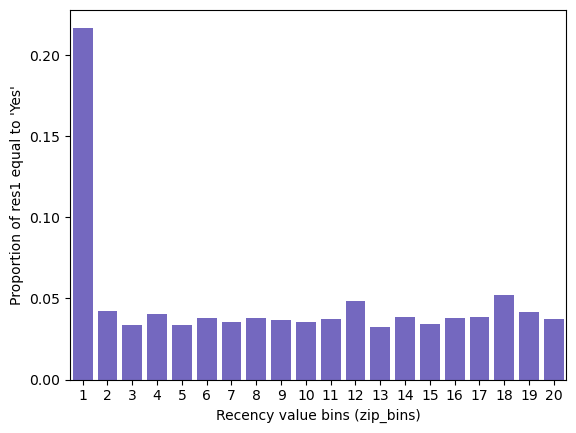

In [21]:
fig1 = rsm.prop_plot(intuit75k[intuit75k['training']==1], "zip_bins", "res1", "Yes")
fig1 = fig1.set_xlabel("Recency value bins (zip_bins)")

Recency Chart : The above graph depicts the proportion of customers who responded "yes" to waive 1 mail that was sent out, per independent zip bin. The customers in bin 1 had the highest response rate from the mail sent out as opposed to ones in the other bins. This graph shows that the recency factor has a constant downgrade after the first bin on the probability of purchasing the latest upgrade offer thru email. Although we can appreciate the biggest drop from bin1 to bin2, which would elevate the predictive probabilities to the group that pertains in bin1 the most.

## 1. Logistic Regression

In [22]:
clf = rsm.model.logistic({"intuit75k_training": intuit75k_training}, 
                         rvar="res1", lev="Yes",
                         evar = [
    "zip_bins",         # Regional influence (aggregated ZIP groups)
    "numords",          # Past purchase frequency
    "dollars",          # Total spend amount
    "last",             # Recency of last purchase
    "version1",         # Whether they have an older version
    "owntaxprod",       # Whether they own Intuit tax software
    "upgraded" ,        # Prior upgrade behavior (predicts likelihood of another upgrade)
    "sex",
    "bizflag",
    "sincepurch"
])
clf.summary()

Logistic regression (GLM)
Data                 : intuit75k_training
Response variable    : res1
Level                : Yes
Explanatory variables: zip_bins, numords, dollars, last, version1, owntaxprod, upgraded, sex, bizflag, sincepurch
Null hyp.: There is no effect of x on res1
Alt. hyp.: There is an effect of x on res1

                 OR     OR%  coefficient  std.error  z.value p.value     
Intercept     0.181  -81.9%        -1.71      0.092  -18.507  < .001  ***
zip_bins[2]   0.148  -85.2%        -1.91      0.110  -17.296  < .001  ***
zip_bins[3]   0.118  -88.2%        -2.14      0.121  -17.710  < .001  ***
zip_bins[4]   0.136  -86.4%        -2.00      0.112  -17.811  < .001  ***
zip_bins[5]   0.116  -88.4%        -2.15      0.120  -17.894  < .001  ***
zip_bins[6]   0.126  -87.4%        -2.07      0.115  -18.043  < .001  ***
zip_bins[7]   0.121  -87.9%        -2.11      0.117  -17.970  < .001  ***
zip_bins[8]   0.131  -86.9%        -2.03      0.114  -17.844  < .001  ***
zip_bins[9

In [23]:
clf.summary(main=False, fit=False, vif=True)


Variance inflation factors:

              vif    Rsq
sincepurch  3.737  0.732
version1    2.972  0.664
upgraded    2.919  0.657
numords     1.558  0.358
dollars     1.527  0.345
owntaxprod  1.027  0.027
last        1.018  0.017
zip_bins    1.003  0.003
sex         1.001  0.001
bizflag     1.000  0.000


In [24]:
clf.summary(main=False, fit=False, test=["sex", "bizflag", "sincepurch"])


Model 1: res1 ~ zip_bins + numords + dollars + last + version1 + owntaxprod + upgraded
Model 2: res1 ~ zip_bins + numords + dollars + last + version1 + owntaxprod + upgraded + sex + bizflag + sincepurch
Pseudo R-squared, Model 1 vs 2: 0.114 vs 0.114
Chi-squared: 1.043 df (4), p.value 0.903


We have removed vaiables sex, bizflag, and sincepurch (since they were not significant), and we keep strong predictors like numords, dollars, last, version1, upgraded. After running a logistic regression of the model with and without the sex, bizflag, and sincepurch variables, we can see that the Pseudo R-squared for both models is 0.114 (when done with training data): This value indicates that, despite the additional variables in Model 2, both models have the same predictive power.

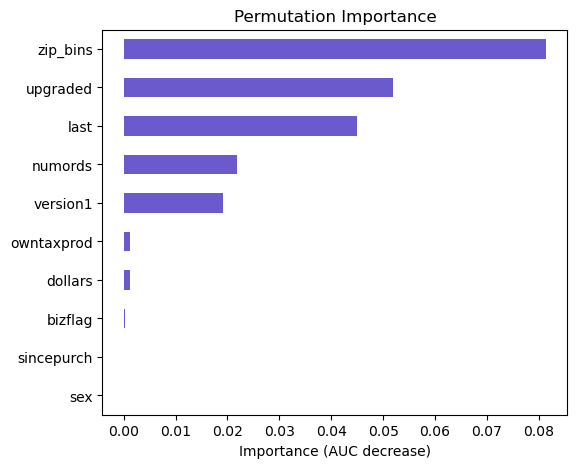

In [25]:
clf.plot(plots="vimp")

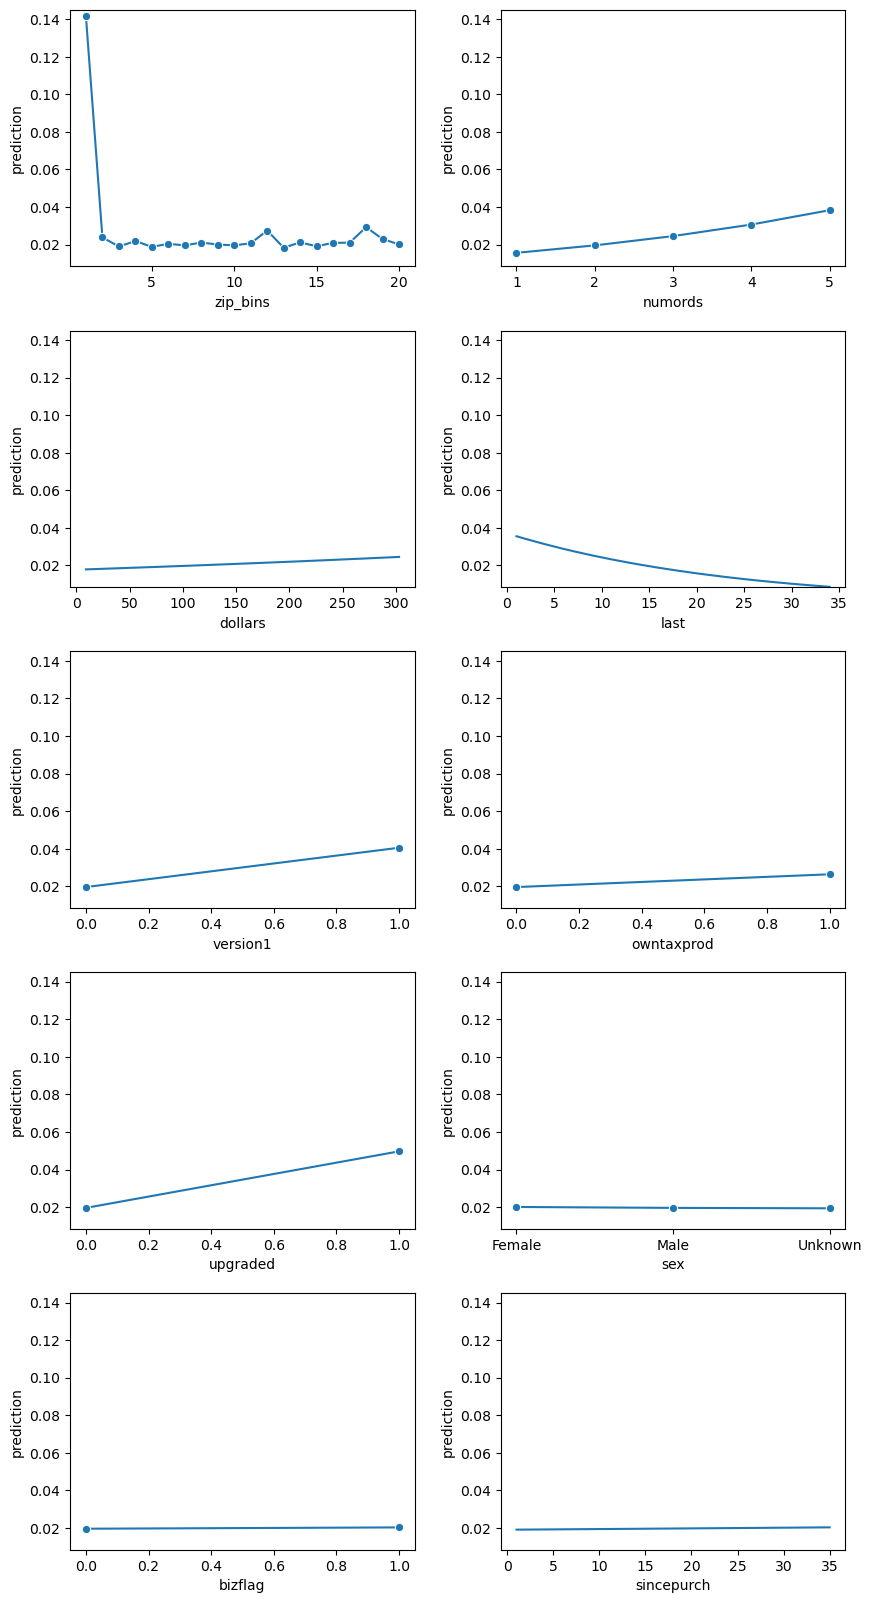

In [26]:
clf.plot("pred")

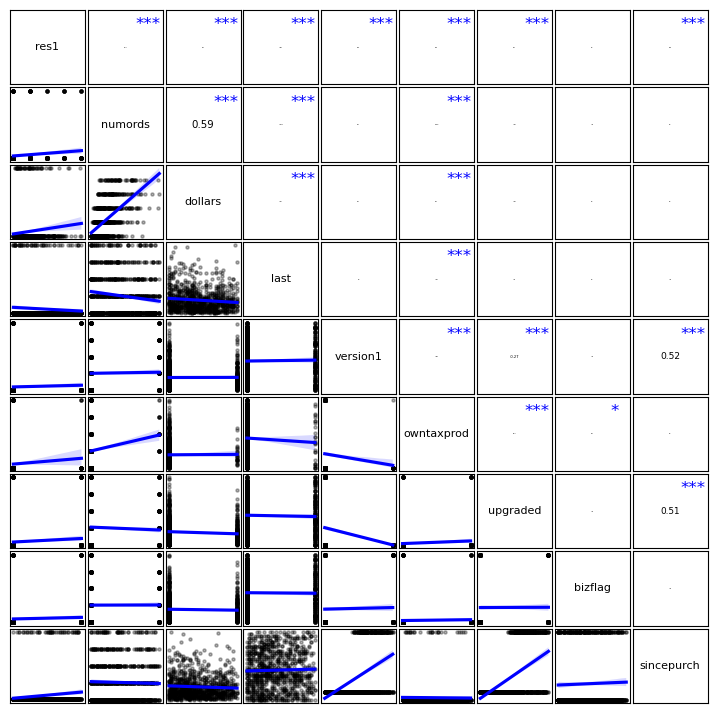

In [27]:
clf.plot("corr")

Now, Testing for Interactions between the variables...

We will test for interactions between zip_bins and all other variables since zip_bins has the greatest number of categories and adds complexity to the model.

In [28]:
clf2 = rsm.model.logistic(
    {"intuit": intuit75k_training},
    rvar="res1_yes",
    lev=1,
    evar=["zip_bins", "sex", "bizflag", "numords", "dollars", "last", "sincepurch", "version1", "owntaxprod", "upgraded"],
    ivar = ["zip_bins:sex", "zip_bins:numords", "zip_bins:dollars", "zip_bins:last", "zip_bins:sincepurch", "zip_bins:version1", "zip_bins:upgraded"],
)

clf2.summary()

Logistic regression (GLM)
Data                 : intuit
Response variable    : res1_yes
Level                : 1
Explanatory variables: zip_bins, sex, bizflag, numords, dollars, last, sincepurch, version1, owntaxprod, upgraded
Null hyp.: There is no effect of x on res1_yes
Alt. hyp.: There is an effect of x on res1_yes

                              OR     OR%  coefficient  std.error  z.value p.value     
Intercept                  0.301  -69.9%        -1.20      0.176   -6.828  < .001  ***
zip_bins[2]                0.071  -92.9%        -2.64      0.447   -5.909  < .001  ***
zip_bins[3]                0.061  -93.9%        -2.79      0.479   -5.820  < .001  ***
zip_bins[4]                0.070  -93.0%        -2.66      0.418   -6.371  < .001  ***
zip_bins[5]                0.075  -92.5%        -2.59      0.444   -5.831  < .001  ***
zip_bins[6]                0.035  -96.5%        -3.36      0.468   -7.175  < .001  ***
zip_bins[7]                0.033  -96.7%        -3.41      0.479   -7

In [29]:
clf2.summary(main=False, fit=False, test=["dollars", "zip_bins:dollars", "sincepurch", "zip_bins:sincepurch"])


Model 1: res1_yes ~ zip_bins + sex + bizflag + numords + last + version1 + owntaxprod + upgraded + zip_bins:last + zip_bins:numords + zip_bins:sex + zip_bins:upgraded + zip_bins:version1
Model 2: res1_yes ~ zip_bins + sex + bizflag + numords + dollars + last + sincepurch + version1 + owntaxprod + upgraded + zip_bins:sex + zip_bins:numords + zip_bins:dollars + zip_bins:last + zip_bins:sincepurch + zip_bins:version1 + zip_bins:upgraded
Pseudo R-squared, Model 1 vs 2: 0.123 vs 0.125
Chi-squared: 49.825 df (40), p.value 0.137


None of the odds ratios of the other variables change significantly after removing the bizflag, sex variable, which suggests that multicollinearity is not a problem in the model. 


However, the bizflag variable is still not significant at the 0.05 level and only a few of the interaction terms are significant at the 0.05 level. We will test the model without this variable.

In [30]:
clf3 = rsm.model.logistic(
    {"intuit": intuit75k_training},
    rvar="res1_yes",
    lev=1,
    evar=["zip_bins", "numords", "dollars", "last", "sincepurch", "version1", "owntaxprod", "upgraded"],
    ivar = ["zip_bins:numords", "zip_bins:last", "zip_bins:version1", "zip_bins:upgraded", "numords:version1", "last:version1"],
)

clf3.summary(main=False, fit=True)


Pseudo R-squared (McFadden): 0.129
Pseudo R-squared (McFadden adjusted): 0.118
Area under the RO Curve (AUC): 0.768
Log-likelihood: -8751.561, AIC: 17713.122, BIC: 18644.321
Chi-squared: 2586.522, df(104), p.value < 0.001 
Nr obs: 52,500


In [31]:
clf3.summary(main=False, fit=False, test=["sincepurch"])


Model 1: res1_yes ~ zip_bins + numords + dollars + last + version1 + owntaxprod + upgraded + last:version1 + numords:version1 + zip_bins:last + zip_bins:numords + zip_bins:upgraded + zip_bins:version1
Model 2: res1_yes ~ zip_bins + numords + dollars + last + sincepurch + version1 + owntaxprod + upgraded + zip_bins:numords + zip_bins:last + zip_bins:version1 + zip_bins:upgraded + numords:version1 + last:version1
Pseudo R-squared, Model 1 vs 2: 0.129 vs 0.129
Chi-squared: 0.239 df (1), p.value 0.625


The chi-squared test comparing the model with sincepurch and the model without sincepurch has a p-value of 0.625, which is greater than the alpha level of 0.05. This indicates that the base model is not significantly different from the model without the sincepurch variable and we can likely remove this term.

The interaction term numords:version1 is included because it helps capture how the number of past orders influences the likelihood of upgrading for customers who still own QuickBooks Version 1. A high number of past orders (numords) generally indicates an engaged customer, but its effect on upgrading might differ based on whether the customer has an outdated version. If this interaction term has a positive coefficient, it would suggest that frequent buyers of Version 1 are more likely to upgrade, as they are actively purchasing from Intuit and may be responsive to an upgrade offer. Conversely, if the coefficient is negative, it may indicate that highly engaged Version 1 users are satisfied with their current version and see no need to upgrade.

The last:version1 interaction term is used to measure whether the recency of the last purchase (last) impacts Version 1 users differently than others. If last:version1 has a negative coefficient, it implies that Version 1 users who have not purchased in a long time are unlikely to upgrade, possibly because they have disengaged from the brand. However, a positive coefficient would suggest that Version 1 users who have delayed purchasing for a long time might be waiting for a compelling upgrade opportunity. This interaction term helps differentiate between long-time Version 1 users who are still potential responders versus those who have become inactive.

In [32]:
clf4 = rsm.model.logistic(
    {"intuit": intuit75k_training},
    rvar="res1_yes",
    lev=1,
    evar=["zip_bins","numords", "last", "version1", "owntaxprod", "upgraded", "dollars"],
    ivar = ["zip_bins:numords", "zip_bins:last", "zip_bins:version1", "zip_bins:upgraded", "numords:version1", "last:version1"],
)

clf4.summary(main=True, fit=True, vif=True)

Logistic regression (GLM)
Data                 : intuit
Response variable    : res1_yes
Level                : 1
Explanatory variables: zip_bins, numords, last, version1, owntaxprod, upgraded, dollars
Null hyp.: There is no effect of x on res1_yes
Alt. hyp.: There is an effect of x on res1_yes

                          OR     OR%  coefficient  std.error  z.value p.value     
Intercept              0.271  -72.9%        -1.31      0.138   -9.505  < .001  ***
zip_bins[2]            0.103  -89.7%        -2.28      0.320   -7.113  < .001  ***
zip_bins[3]            0.107  -89.3%        -2.24      0.350   -6.404  < .001  ***
zip_bins[4]            0.091  -90.9%        -2.40      0.325   -7.393  < .001  ***
zip_bins[5]            0.086  -91.4%        -2.45      0.344   -7.115  < .001  ***
zip_bins[6]            0.054  -94.6%        -2.91      0.352   -8.259  < .001  ***
zip_bins[7]            0.048  -95.2%        -3.03      0.356   -8.500  < .001  ***
zip_bins[8]            0.095  -90.5%    

In [33]:
intuit75k["pred_logit"] = clf4.predict(data=intuit75k)["prediction"]
intuit75k["pred_logit"].head(-1)

0        0.039815
1        0.032531
2        0.076732
3        0.160247
4        0.024886
           ...   
74994    0.012493
74995    0.046590
74996    0.007268
74997    0.039920
74998    0.035565
Name: pred_logit, Length: 74999, dtype: float64

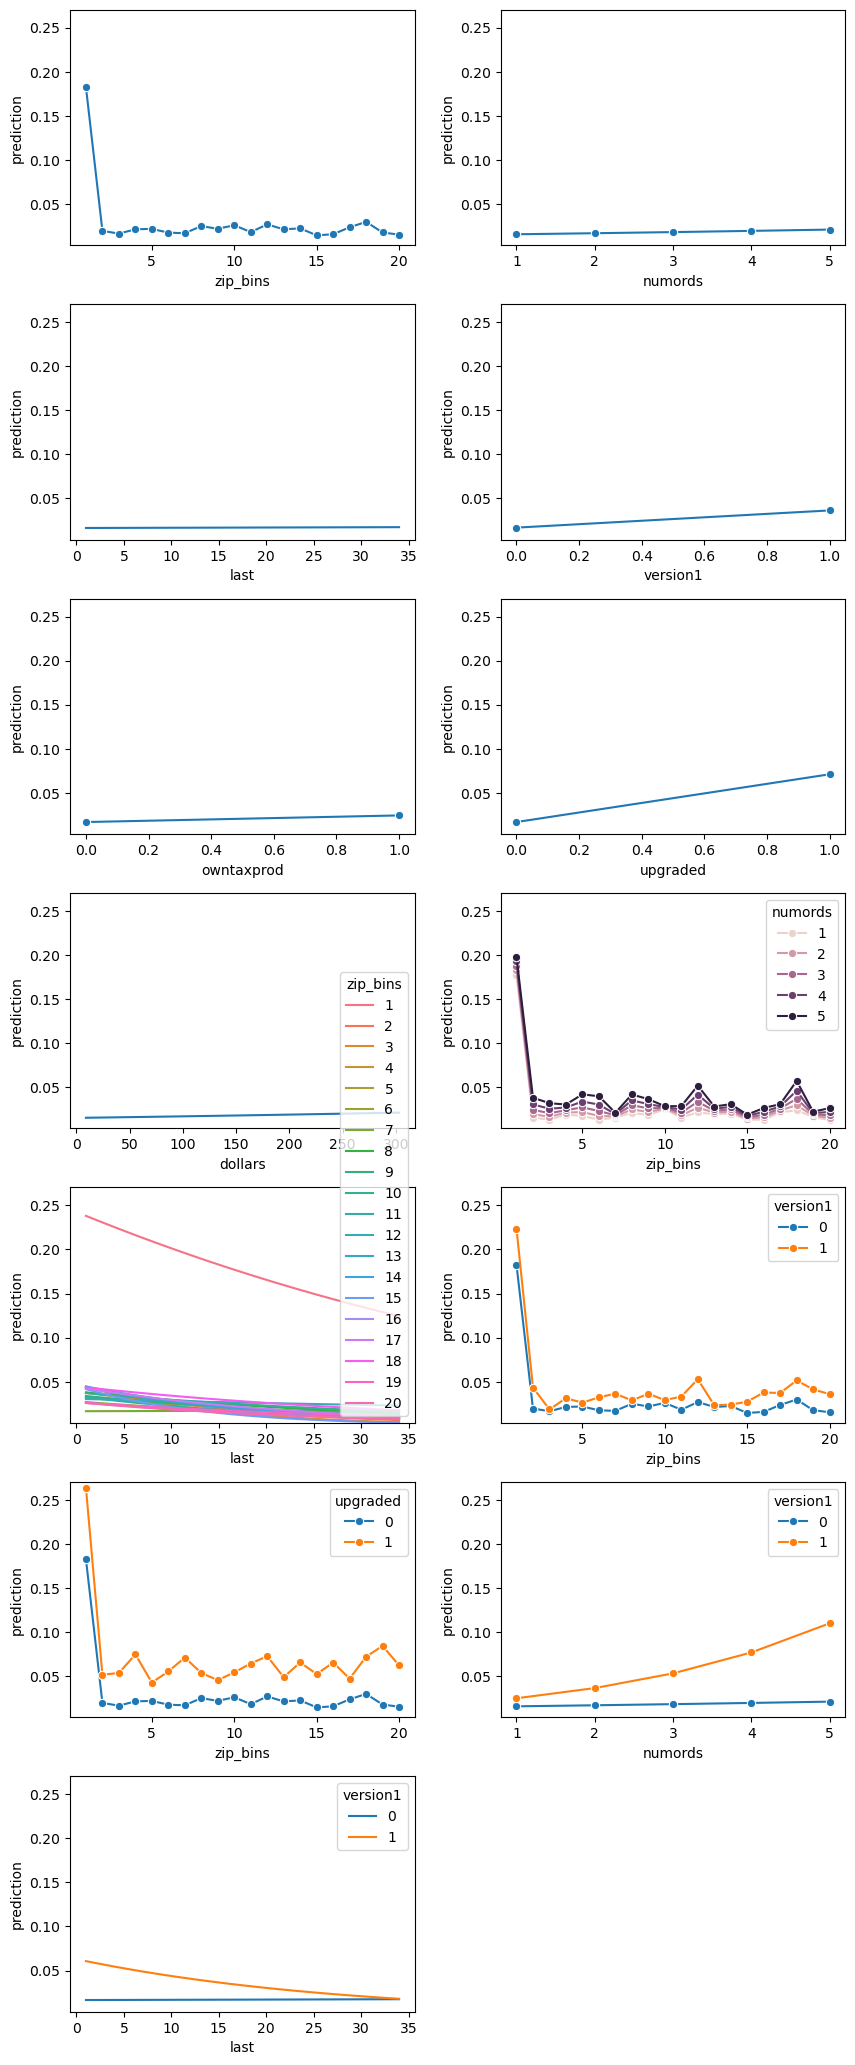

In [34]:
clf4.plot("pred", incl_int=["zip_bins:numords", "zip_bins:last", "zip_bins:version1", "zip_bins:upgraded", "numords:version1", "last:version1"])

The prediction plots illustrate how the likelihood of businesses responding to a QuickBooks upgrade offer varies based on different predictor variables while keeping all other factors unchanged.

**zip_bins vs. prediction**

Businesses in the first zip_bin have a significantly higher probability of responding compared to those in other bins. After the first bin, response probability drops sharply and remains relatively stable.

**numords vs. prediction**

There is a positive linear relationship between the number of previous orders (numords) and the probability of response. This indicates that businesses with more past orders are more likely to accept the upgrade offer.

**last vs. prediction**

The probability of responding decreases as the time since the last order (last) increases. This suggests that businesses that have not ordered in a long time are less likely to respond.

**version1 vs. prediction**

Businesses using version 1 of QuickBooks show a slightly higher likelihood of responding compared to those using other versions.

**owntaxprod vs. prediction**

Businesses that own tax-related products (owntaxprod) have a slightly higher probability of responding compared to those that do not.

**upgraded vs. prediction**

Businesses that have previously upgraded show a higher probability of responding, indicating that prior upgrades make businesses more likely to upgrade again.

**dollars vs. prediction**

The probability of responding increases with spending, suggesting that businesses that spend more are more likely to respond positively to the upgrade offer.

**zip_bins vs. prediction (colored by numords)**

While response probability drops sharply after the first zip_bin, businesses with a higher number of past orders (numords) tend to have slightly higher response probabilities across all bins.

**last vs. prediction (colored by zip_bins)**

The likelihood of response decreases as time since the last order increases. However, businesses in the first zip_bin consistently exhibit a much higher probability of responding compared to others.

**zip_bins vs. prediction (colored by version1)**

Businesses using version 1 (orange line) generally show a slightly higher probability of responding across all zip_bins.

**zip_bins vs. prediction (colored by upgraded status)**

Businesses that have previously upgraded (orange line) exhibit a consistently higher probability of responding across all zip_bins compared to those that have not upgraded before (blue line).

**numords vs. prediction (colored by version1)**

Businesses using version 1 of QuickBooks (orange line) display a stronger positive relationship between the number of past orders and response probability.

**last vs. prediction (colored by version1)**

The probability of responding declines as the time since the last order increases. However, businesses using version 1 (orange line) maintain a higher likelihood of responding than those using other versions.

#### Model Evaluation

In [35]:
intuit75k["pred_logit_wave1"] = clf4.predict(data=intuit75k)["prediction"]

# Predictions for wave 2 (50% of probability of wave 1)
intuit75k["pred_logit_wave2"] = clf4.predict(data=intuit75k)["prediction"] * 0.5

We used the selected model (clf4) to estimate the probability of a positive response to the QuickBooks upsell campaign. The intuit75k dataframe includes the columns pred_logit_wave1 and pred_logit_wave2, which store the predicted probabilities for the first and second waves of the campaign, respectively.

For wave 2, the predicted probabilities are assumed to be 50% of those from wave 1. This assumption is based on the expectation that response rates will be lower in the second wave, as the businesses most likely to respond have already done so in the first wave.

Calculating breakeven rate

In [36]:
cost_per_mail = 1.41
revenue_per_responder = 60

breakeven = cost_per_mail / revenue_per_responder
print(f"Breakeven rate: {breakeven:.2%}")

Breakeven rate: 2.35%


In [37]:
# Decile predictions for wave 1 grouped by training
intuit75k["pred_logit_dec"] = (
    intuit75k
    .groupby("training")
    .pred_logit_wave1
    .transform(rsm.xtile, 10, rev=True)
)

In [38]:
# Decile table for wave 1 predictions grouped by training
dec_tab = (
    intuit75k
    .groupby([ "training", "pred_logit_dec"])
    .agg(
        num_obs=("pred_logit_wave1", "count"), 
        num_responses=("res1_yes", lambda x: x.sum()),
        response_rate_w1=("res1_yes", "mean"), 
    )
    .reset_index()
    .sort_values(by=["training", "pred_logit_dec"], ascending=[True,True]) 
)

dec_tab

,training,pred_logit_dec,num_obs,num_responses,response_rate_w1
0,0,1,2250,441,0.196000
1,0,2,2250,159,0.070667
2,0,3,2250,135,0.060000
3,0,4,2250,88,0.039111
4,0,5,2250,72,0.032000
5,0,6,2250,50,0.022222
6,0,7,2249,56,0.024900
7,0,8,2251,37,0.016437
8,0,9,2250,41,0.018222
9,0,10,2250,24,0.010667


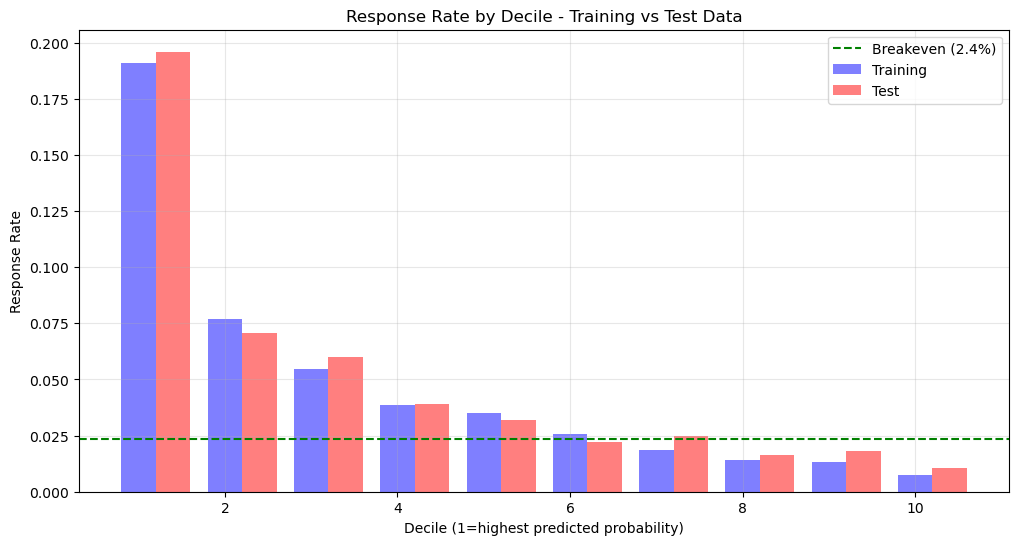

In [39]:
# Create bar chart
plt.figure(figsize=(12, 6))

# Plot training data bars
plt.bar(dec_tab[dec_tab['training']==1]['pred_logit_dec'], 
    dec_tab[dec_tab['training']==1]['response_rate_w1'],
    alpha=0.5,
    label='Training',
    color='blue',
    width=0.4)

# Plot test data bars
plt.bar(dec_tab[dec_tab['training']==0]['pred_logit_dec'] + 0.4, 
    dec_tab[dec_tab['training']==0]['response_rate_w1'],
    alpha=0.5,
    label='Test',
    color='red',
    width=0.4)

# Customize the plot
plt.xlabel('Decile (1=highest predicted probability)')
plt.ylabel('Response Rate')
plt.title('Response Rate by Decile - Training vs Test Data')
plt.legend()
plt.grid(True, alpha=0.3)

# Add horizontal line for breakeven rate
plt.axhline(y=breakeven, color='green', linestyle='--', label=f'Breakeven ({breakeven:.1%})')
plt.legend()

plt.show()

Our aim is to assess the predictive accuracy of the chosen model by analyzing response rates across deciles of predicted probabilities. Predictions are divided into ten groups (deciles), and the actual response rates for each are calculated and compared between the training and test datasets. A bar chart is used to visualize these response rates, where ideally, higher deciles correspond to a greater likelihood of response. The model demonstrates strong performance, as the highest response rate is observed in the first decile, indicating its effectiveness in identifying businesses most likely to engage with the campaign.

In [40]:
# Creating a lift table for wave 1 predictions, segmented by training data
lift_table = dec_tab[['pred_logit_dec', 'training', 'num_obs', 'num_responses', 'response_rate_w1']].copy()

# Computing cumulative counts within each training group
lift_table["cumulative_obs"] = lift_table.groupby('training')['num_obs'].cumsum()
lift_table["cumulative_responses"] = lift_table.groupby('training')['num_responses'].cumsum()

# Calculating the cumulative proportion of observations
lift_table["cumulative_obs_proportion"] = lift_table.groupby('training')['cumulative_obs'].transform(lambda x: x / x.iloc[-1])

# Deriving cumulative response rate
lift_table["cumulative_response_rate"] = lift_table["cumulative_responses"] / lift_table["cumulative_obs"]

# Computing the overall average response rate for each training group
avg_response_rate = lift_table.groupby('training').apply(lambda x: x['num_responses'].sum() / x['num_obs'].sum()).reset_index(name='overall_avg_response_rate')

# Merging the average response rate into the lift table
lift_table = lift_table.merge(avg_response_rate, on='training')

# Calculating lift, which measures how much a given decile outperforms the average response rate
lift_table["lift"] = lift_table['response_rate_w1'] / lift_table.groupby('training')['response_rate_w1'].transform('mean')

# Determining cumulative lift by comparing cumulative response rate to the overall average
lift_table["cumulative_lift"] = lift_table["cumulative_response_rate"] / lift_table['overall_avg_response_rate']


/tmp/ipykernel_96028/2898334160.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_response_rate = lift_table.groupby('training').apply(lambda x: x['num_responses'].sum() / x['num_obs'].sum()).reset_index(name='overall_avg_response_rate')


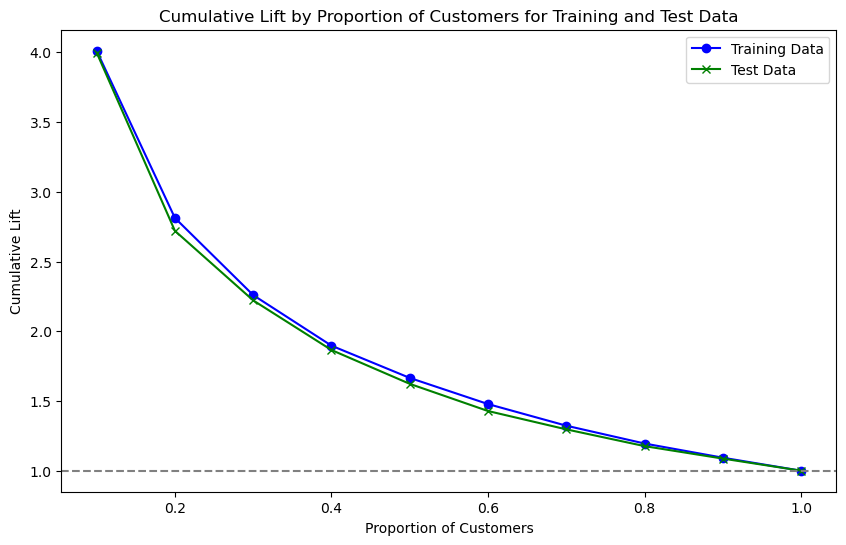

In [41]:
# Initializing the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Splitting training and test data
training_data = lift_table[lift_table['training'] == 1]
test_data = lift_table[lift_table['training'] == 0]

# Plotting cumulative lift for training and test datasets
ax.plot(training_data["cumulative_obs_proportion"], training_data["cumulative_lift"], color='blue', marker='o', label='Training Data')
ax.plot(test_data["cumulative_obs_proportion"], test_data["cumulative_lift"], color='green', marker='x', label='Test Data')

# Adding a reference line at y=1 for baseline comparison
ax.axhline(1, color="gray", linestyle="--")

# Setting labels and title
ax.set_xlabel("Proportion of Customers")
ax.set_ylabel("Cumulative Lift")
ax.set_title("Cumulative Lift by Proportion of Customers for Training and Test Data")

# Displaying legend
ax.legend()

# Showing the plot
plt.show()

The cumulative lift chart illustrates the model’s effectiveness in ranking customers based on their likelihood to respond to the campaign. The blue line represents the training data, while the green line represents the test data, and their close alignment suggests that the model generalizes well to unseen data without significant overfitting.

At the start, the cumulative lift is around 4.0, indicating that the model successfully prioritizes the most responsive customers first. As more customers are included, the cumulative lift gradually declines, which is expected since lower-ranked customers have a lower probability of responding. However, the model consistently outperforms random selection, as both curves remain above the dashed baseline at a lift value of 1.0. 

This confirms that the model adds value by improving the selection of high-response customers, ensuring a more efficient marketing strategy. The strong consistency between training and test results reinforces confidence in the model’s reliability for future customer targeting.

In [42]:

# Creating a modified gains table using cumulative response calculations
gains_table = lift_table[['pred_logit_dec', 'training', 'cumulative_obs_proportion', 'num_responses']].copy()

# Computing cumulative responses within each dataset (training and test)
gains_table['cumulative_responses'] = gains_table.groupby('training')['num_responses'].transform('cumsum')

# Calculating the proportion of responses captured per decile
gains_table["gains"] = gains_table['num_responses'] / gains_table.groupby('training')['num_responses'].transform('sum')

# Determining cumulative gains as we progress through deciles
gains_table["cumulative_gains"] = gains_table['cumulative_responses'] / gains_table.groupby('training')['num_responses'].transform('sum')

# Adding an initial zero reference point for both training and test datasets
zero_entry_training = pd.DataFrame({
    'pred_logit_dec': [0], 'training': [1], 'cumulative_obs_proportion': [0], 
    'num_responses': [0], 'cumulative_responses': [0], 'gains': [0], 'cumulative_gains': [0]
})

zero_entry_test = pd.DataFrame({
    'pred_logit_dec': [0], 'training': [0], 'cumulative_obs_proportion': [0], 
    'num_responses': [0], 'cumulative_responses': [0], 'gains': [0], 'cumulative_gains': [0]
})

# Merging the zero reference rows with the main dataset
gains_table = pd.concat([zero_entry_training, zero_entry_test, gains_table], ignore_index=True)

# Sorting the table based on training indicator and decile order
gains_table.sort_values(by=['training', 'pred_logit_dec'], inplace=True)
gains_table.reset_index(drop=True, inplace=True)


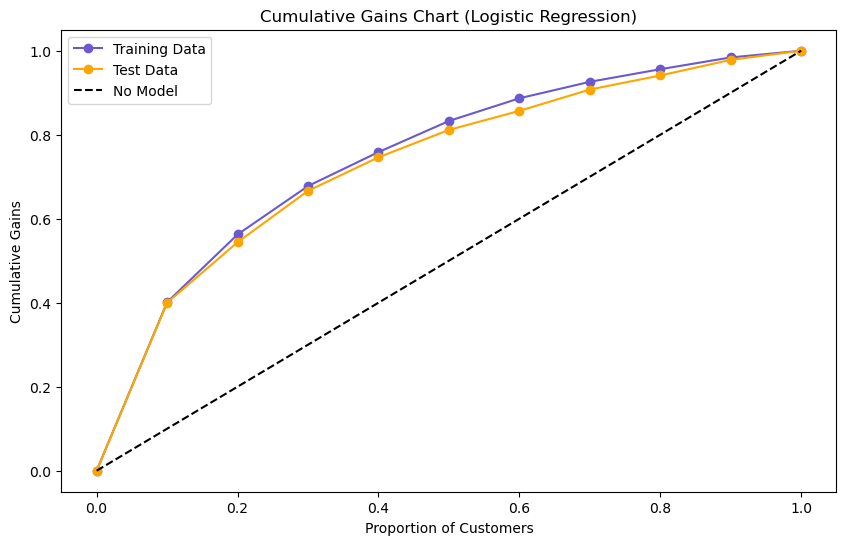

In [43]:
# Separating training and test datasets
training_data = gains_table[gains_table['training'] == 1]
test_data = gains_table[gains_table['training'] == 0]

# Initialize the figure
plt.figure(figsize=(10, 6))

# Plot cumulative gains for training and test data
plt.plot(training_data['cumulative_obs_proportion'], training_data['cumulative_gains'], 
         color='slateblue', label='Training Data', marker='o')

plt.plot(test_data['cumulative_obs_proportion'], test_data['cumulative_gains'], 
         color='orange', label='Test Data', marker='o')

# Adding a reference diagonal line representing a random selection strategy
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='No Model')

# Setting labels and title
plt.xlabel('Proportion of Customers')
plt.ylabel('Cumulative Gains')
plt.title('Cumulative Gains Chart (Logistic Regression)')

# Displaying the legend
plt.legend()

# Show the plot
plt.show()


The Cumulative Gains Chart evaluates the logistic regression model’s effectiveness in ranking customers based on their likelihood to respond. The purple curve represents the training data, while the orange curve represents the test data, both of which closely align, indicating that the model generalizes well and is not overfitting. The steep initial rise in both curves demonstrates that the model successfully prioritizes the most responsive customers, capturing nearly 60% of responses by targeting only 20% of the customer base. In contrast, the black dashed diagonal line represents a random selection baseline, which the model significantly outperforms. The further the gains curve is above this diagonal, the better the model is at distinguishing high-response customers from low-response ones. Since the test data follows the same trend as the training data, the model's predictive power remains consistent across unseen data, making it a reliable tool for optimizing the QuickBooks upsell campaign.

In [44]:
intuit75k["mail_wave1"] = intuit75k.pred_logit_wave1 > breakeven

In [45]:
TP = intuit75k[(intuit75k.training == 0) & (intuit75k.res1_yes == 1) & (intuit75k.mail_wave1 == True)].shape[0]
FP = intuit75k[(intuit75k.training == 0) & (intuit75k.res1_yes == 0) & (intuit75k.mail_wave1 == True)].shape[0]
TN = intuit75k[(intuit75k.training == 0) & (intuit75k.res1_yes == 0) & (intuit75k.mail_wave1 == False)].shape[0]
FN = intuit75k[(intuit75k.training == 0) & (intuit75k.res1_yes == 1) & (intuit75k.mail_wave1 == False)].shape[0]

In [46]:
# Confusion matrix for wave 1
cm_logit = pd.DataFrame(
    {
        "label": ["TP", "FP", "TN", "FN"],
        "nr": [
            TP,
            FP,
            TN,
            FN
        ]
    }
)

cm_logit

,label,nr
0,TP,935
1,FP,11942
2,TN,9455
3,FN,168


In [47]:
# Metrics for wave 1
accuracy = (TP + TN) / (TP + FP + TN + FN)

recall = TP / (TP + FN)

precision = TP / (TP + FP)

specificity = TN / (FP + TN)

print(f"Accuracy: {accuracy:.2%},\nRecall: {recall:.2%},\nPrecision: {precision:.2%},\nSpecificity: {specificity:.2%}")

Accuracy: 46.18%,
Recall: 84.77%,
Precision: 7.26%,
Specificity: 44.19%


**Accuracy (46.18%)**

The model correctly classifies 46.18% of the total instances. However, given the imbalance between precision and recall, accuracy alone may not be the best indicator of performance.

**Recall (84.77%)**

This is very high, meaning the model is capturing most of the actual positive cases (i.e., businesses that do respond to the upgrade offer). A high recall is beneficial if the goal is to minimize false negatives.

**Precision (7.26%)**

This is extremely low, meaning that among the businesses predicted to respond, only a small fraction actually do. This suggests a high false positive rate, where the model predicts a response, but the business does not actually respond.

**Specificity (44.19%)**

The model correctly identifies 44.19% of the non-responding businesses, meaning it is not very strong in rejecting non-responders.

The model demonstrates a high recall (84.77%), indicating it successfully identifies most businesses likely to respond to the upgrade offer. However, the precision is extremely low (7.26%), meaning that a large proportion of the predicted responders do not actually respond, leading to a high false positive rate. With an accuracy of 46.18% and a specificity of 44.19%, the model struggles to correctly classify non-responders. This suggests it is biased toward predicting positive responses, which may lead to wasted resources if outreach efforts are based on these predictions.

In [48]:
#training data

cost_per_mail = 1.41
revenue_per_response = 60
intuit75k_training['mail_wave1'] = intuit75k['pred_logit_wave1'] > breakeven
mail_per = intuit75k_training['mail_wave1'].mean()
mail_data = intuit75k_training[intuit75k_training['mail_wave1']]
num_mail = mail_data.shape[0]
response_rate = (mail_data['res1'] == 'Yes').mean()
num_responses = (mail_data['res1'] == 'Yes').sum()
total_revenue = num_responses * revenue_per_response
total_mail_cost = num_mail * cost_per_mail
profit = total_revenue - total_mail_cost
ROME = profit / total_mail_cost
    
output = f"""
- Intuit should focus on reaching out to approximately {(num_mail):,.0f} customers, which represents {100 * mail_per:.2f}% of the total.
- The anticipated response rate for these selected customers is {100 * response_rate:.2f}%, translating to around {num_responses:,.0f} responses.
- The projected revenue from this campaign is estimated at ${total_revenue:,.2f}.
- The expected profit stands at ${profit:,.2f}.
- The total cost of mailing is estimated at ${total_mail_cost:,.2f}, with a Return on Marketing Effort (ROME) of {100 * ROME:.2f}%.
"""
        
print(output)
    
print(response_rate, mail_per)


- Intuit should focus on reaching out to approximately 29,721 customers, which represents 56.61% of the total.
- The anticipated response rate for these selected customers is 7.30%, translating to around 2,169 responses.
- The projected revenue from this campaign is estimated at $130,140.00.
- The expected profit stands at $88,233.39.
- The total cost of mailing is estimated at $41,906.61, with a Return on Marketing Effort (ROME) of 210.55%.

0.07297870192792974 0.5661142857142857


/tmp/ipykernel_96028/2879661793.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intuit75k_training['mail_wave1'] = intuit75k['pred_logit_wave1'] > breakeven


To estimate the expected response rate, we analyzed the model’s performance using training data. This evaluation relied on predicted probabilities from the wave-1 mailing campaign, as the available response data corresponds to that campaign. The projected response rate is 7.3%, meaning we anticipate 7.3% of the contacted businesses to engage with the upsell offer. This expected response rate provides a basis for calculating the forecasted profit from the campaign.

In [49]:
intuit75k["mail_wave2"] = intuit75k.pred_logit_wave2 > breakeven
intuit75k[intuit75k['training'] == 0].head(-1)
intuit75k_test['mail_wave2'] = intuit75k['pred_logit_wave2'] > breakeven
intuit75k_test.head()

/tmp/ipykernel_96028/1410465964.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intuit75k_test['mail_wave2'] = intuit75k['pred_logit_wave2'] > breakeven


,id,zip5,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,res1,training,res1_yes,mail_wave2
1,2,53190,10,Unknown,0,1,69.5,4,3,0,0,0,No,0,0,False
2,3,37091,8,Male,0,4,93.0,14,29,0,0,1,No,0,0,True
4,5,60201,11,Male,0,1,24.5,2,3,0,0,0,No,0,0,False
6,7,22980,5,Male,0,1,49.5,13,36,1,0,0,No,0,0,False
8,9,34950,8,Male,0,1,44.5,15,4,0,0,0,No,0,0,False


In [50]:
#test data

cost_per_mail = 1.41
revenue_per_response = 60
mail_per = intuit75k_test['mail_wave2'].mean()
mail_data = intuit75k_test[intuit75k_test['mail_wave2']]
num_mail = mail_data.shape[0]
num_responses = num_mail * response_rate
total_revenue = num_responses * revenue_per_response
total_mail_cost = num_mail * cost_per_mail
profit = total_revenue - total_mail_cost
ROME = profit / total_mail_cost
    
output = f"""
- Intuit should focus on reaching out to approximately {(num_mail):,.0f} customers, which represents {100 * mail_per:.2f}% of the total.
- The anticipated response rate for these selected customers is {100 * response_rate:.2f}%, translating to around {num_responses:,.0f} responses.
- The projected revenue from this campaign is estimated at ${total_revenue:,.2f}.
- The expected profit stands at ${profit:,.2f}.
- The total cost of mailing is estimated at ${total_mail_cost:,.2f}, with a Return on Marketing Effort (ROME) of {100 * ROME:.2f}%.
"""
        
print(output)
print(response_rate, mail_per)


- Intuit should focus on reaching out to approximately 6,539 customers, which represents 29.06% of the total.
- The anticipated response rate for these selected customers is 7.30%, translating to around 477 responses.
- The projected revenue from this campaign is estimated at $28,632.46.
- The expected profit stands at $19,412.47.
- The total cost of mailing is estimated at $9,219.99, with a Return on Marketing Effort (ROME) of 210.55%.

0.07297870192792974 0.2906222222222222


In [51]:
total_cust = 801828
responses = 38487 #these should not be mailed again

In [52]:
cost_per_mail = 1.41
revenue_per_response = 60
num_customers = total_cust - responses
num_mail = num_customers * mail_per
num_responses = num_mail * response_rate
total_revenue = num_responses * revenue_per_response
total_mail_cost = num_mail * cost_per_mail
profit = total_revenue - total_mail_cost
ROME = profit / total_mail_cost
    
output = f"""
- Intuit should focus on reaching out to approximately {(num_mail):,.0f} customers, which represents {100 * mail_per:.2f}% of the total.
- The anticipated response rate for these selected customers is {100 * response_rate:.2f}%, translating to around {num_responses:,.0f} responses.
- The projected revenue from this campaign is estimated at ${total_revenue:,.2f}.
- The expected profit stands at ${profit:,.2f}.
- The total cost of mailing is estimated at ${total_mail_cost:,.2f}, with a Return on Marketing Effort (ROME) of {100 * ROME:.2f}%.
"""
        
print(output)
print(response_rate, mail_per)


- Intuit should focus on reaching out to approximately 221,844 customers, which represents 29.06% of the total.
- The anticipated response rate for these selected customers is 7.30%, translating to around 16,190 responses.
- The projected revenue from this campaign is estimated at $971,392.61.
- The expected profit stands at $658,592.77.
- The total cost of mailing is estimated at $312,799.84, with a Return on Marketing Effort (ROME) of 210.55%.

0.07297870192792974 0.2906222222222222


Using the response rate derived from the training data and the percentage of the customer base targeted in the test data, we can estimate the overall impact of the direct mail campaign on a larger customer base, excluding those who have already responded. The campaign is expected to reach 221,844 businesses, representing 29.06% of the remaining customer base. This effort is projected to yield 16,190 positive responses, resulting in a profit of $658,692.77 and a Return on Marketing Effort (ROME) of 210.55%.

## 2. Nueral Network

We begin by standardizing the data...

In [54]:
# hidden_layer_sizes=[1,]

In [55]:
nnr1 = rsm.model.mlp(
    data={"intuit75k_training": intuit75k_training},
    rvar="res1",
    lev="Yes",
    evar = [
    "zip_bins",        
    "numords",        
    "dollars",         
    "last",             
    "version1",        
    "owntaxprod",      
    "upgraded",
    "sex",
    "bizflag",
    "sincepurch"
],
    hidden_layer_sizes=[1,],
)

nnr1.summary()

Multi-layer Perceptron (NN)
Data                 : intuit75k_training
Response variable    : res1
Level                : Yes
Explanatory variables: zip_bins, numords, dollars, last, version1, owntaxprod, upgraded, sex, bizflag, sincepurch
Model type           : classification
Nr. of features      : (10, 29)
Nr. of weights       : 30
Nr. of observations  : 52,500
Hidden_layer_sizes   : [1]
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0.0001
Batch size           : auto
Learning rate        : 0.001
Maximum iterations   : 1000000
random_state         : 1234
AUC                  : 0.756

Raw data             :
zip_bins  numords  dollars  last  version1  owntaxprod  upgraded  sex  bizflag  sincepurch
      18        2    109.5     5         0           0         0 Male        0          12
       1        1     22.0    17         0           0         0 Male        0           1
       3        1     20.0    17         0           0         1 Male        0 

In [56]:
# hidden_layer_sizes=[2,]

In [57]:
nnr2 = rsm.model.mlp(
    data={"intuit75k_training": intuit75k_training},
    rvar="res1",
    lev="Yes",
    evar = [
    "zip_bins",        
    "numords",        
    "dollars",         
    "last",             
    "version1",        
    "owntaxprod",      
    "upgraded",
    "sex",
    "bizflag",
    "sincepurch"
],
    hidden_layer_sizes=[2,],
)

nnr2.summary()

Multi-layer Perceptron (NN)
Data                 : intuit75k_training
Response variable    : res1
Level                : Yes
Explanatory variables: zip_bins, numords, dollars, last, version1, owntaxprod, upgraded, sex, bizflag, sincepurch
Model type           : classification
Nr. of features      : (10, 29)
Nr. of weights       : 60
Nr. of observations  : 52,500
Hidden_layer_sizes   : [2]
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0.0001
Batch size           : auto
Learning rate        : 0.001
Maximum iterations   : 1000000
random_state         : 1234
AUC                  : 0.764

Raw data             :
zip_bins  numords  dollars  last  version1  owntaxprod  upgraded  sex  bizflag  sincepurch
      18        2    109.5     5         0           0         0 Male        0          12
       1        1     22.0    17         0           0         0 Male        0           1
       3        1     20.0    17         0           0         1 Male        0 

In [58]:
# hidden_layer_sizes=[10,]

In [59]:
nnr10 = rsm.model.mlp(
    data={"intuit75k_training": intuit75k_training},
    rvar="res1",
    lev="Yes",
    evar = [
    "zip_bins",        
    "numords",        
    "dollars",         
    "last",             
    "version1",        
    "owntaxprod",      
    "upgraded",
    "sex",
    "bizflag",
    "sincepurch"
],
    hidden_layer_sizes=[10,],
)

nnr10.summary()

Multi-layer Perceptron (NN)
Data                 : intuit75k_training
Response variable    : res1
Level                : Yes
Explanatory variables: zip_bins, numords, dollars, last, version1, owntaxprod, upgraded, sex, bizflag, sincepurch
Model type           : classification
Nr. of features      : (10, 29)
Nr. of weights       : 300
Nr. of observations  : 52,500
Hidden_layer_sizes   : [10]
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0.0001
Batch size           : auto
Learning rate        : 0.001
Maximum iterations   : 1000000
random_state         : 1234
AUC                  : 0.784

Raw data             :
zip_bins  numords  dollars  last  version1  owntaxprod  upgraded  sex  bizflag  sincepurch
      18        2    109.5     5         0           0         0 Male        0          12
       1        1     22.0    17         0           0         0 Male        0           1
       3        1     20.0    17         0           0         1 Male        

In [60]:
nnr3 = rsm.model.mlp(
    data={"intuit75k_training": intuit75k_training},
    rvar="res1",
    lev="Yes",
    evar = [
    "zip_bins",        
    "numords",        
    "dollars",         
    "last",             
    "version1",        
    "owntaxprod",      
    "upgraded",
    "sex",
    "bizflag",
    "sincepurch"
],
    hidden_layer_sizes=[3,],
)

nnr3.summary()

Multi-layer Perceptron (NN)
Data                 : intuit75k_training
Response variable    : res1
Level                : Yes
Explanatory variables: zip_bins, numords, dollars, last, version1, owntaxprod, upgraded, sex, bizflag, sincepurch
Model type           : classification
Nr. of features      : (10, 29)
Nr. of weights       : 90
Nr. of observations  : 52,500
Hidden_layer_sizes   : [3]
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0.0001
Batch size           : auto
Learning rate        : 0.001
Maximum iterations   : 1000000
random_state         : 1234
AUC                  : 0.766

Raw data             :
zip_bins  numords  dollars  last  version1  owntaxprod  upgraded  sex  bizflag  sincepurch
      18        2    109.5     5         0           0         0 Male        0          12
       1        1     22.0    17         0           0         0 Male        0           1
       3        1     20.0    17         0           0         1 Male        0 

In [61]:
intuit75k['pred_nnr1'] = nnr1.predict(intuit75k)["prediction"]

In [62]:
intuit75k['pred_nnr2'] = nnr2.predict(intuit75k)["prediction"]

In [63]:

intuit75k['pred_nnr10'] = nnr10.predict(intuit75k)["prediction"]

In [64]:
intuit75k['pred_nnr3'] = nnr3.predict(intuit75k)["prediction"]

In [65]:
intuit75k

,id,zip5,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,...,pred_logit,pred_logit_wave1,pred_logit_wave2,pred_logit_dec,mail_wave1,mail_wave2,pred_nnr1,pred_nnr2,pred_nnr10,pred_nnr3
0,1,94553,18,Male,0,2,109.5,5,12,0,...,0.039815,0.039815,0.019908,4,True,False,0.040269,0.040674,0.027965,0.043903
1,2,53190,10,Unknown,0,1,69.5,4,3,0,...,0.032531,0.032531,0.016265,5,True,False,0.020036,0.027513,0.026704,0.028420
2,3,37091,8,Male,0,4,93.0,14,29,0,...,0.076732,0.076732,0.038366,2,True,True,0.096701,0.071984,0.131371,0.074607
3,4,02125,1,Male,0,1,22.0,17,1,0,...,0.160247,0.160247,0.080123,1,True,True,0.131114,0.141847,0.160992,0.141647
4,5,60201,11,Male,0,1,24.5,2,3,0,...,0.024886,0.024886,0.012443,6,True,False,0.023586,0.026844,0.033358,0.024084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74995,74996,28205,6,Male,1,4,211.5,5,15,0,...,0.046590,0.046590,0.023295,3,True,False,0.056728,0.043183,0.051983,0.044903
74996,74997,94806,18,Male,0,1,4.5,35,34,1,...,0.007268,0.007268,0.003634,10,False,False,0.017363,0.011589,0.013953,0.012298
74997,74998,72958,13,Female,1,1,54.5,4,19,1,...,0.039920,0.039920,0.019960,4,True,False,0.049337,0.031099,0.064447,0.031889
74998,74999,29464,6,Male,0,1,69.5,20,27,0,...,0.035565,0.035565,0.017783,4,True,False,0.031744,0.041167,0.030371,0.037553


In [66]:
# Create subset of test data
test_subset = intuit75k[intuit75k['training'] == 0]
test_subset.head()

,id,zip5,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,...,pred_logit,pred_logit_wave1,pred_logit_wave2,pred_logit_dec,mail_wave1,mail_wave2,pred_nnr1,pred_nnr2,pred_nnr10,pred_nnr3
1,2,53190,10,Unknown,0,1,69.5,4,3,0,...,0.032531,0.032531,0.016265,5,True,False,0.020036,0.027513,0.026704,0.028420
2,3,37091,8,Male,0,4,93.0,14,29,0,...,0.076732,0.076732,0.038366,2,True,True,0.096701,0.071984,0.131371,0.074607
4,5,60201,11,Male,0,1,24.5,2,3,0,...,0.024886,0.024886,0.012443,6,True,False,0.023586,0.026844,0.033358,0.024084
6,7,22980,5,Male,0,1,49.5,13,36,1,...,0.017189,0.017189,0.008594,8,False,False,0.030855,0.019273,0.017286,0.019649
8,9,34950,8,Male,0,1,44.5,15,4,0,...,0.020019,0.020019,0.010010,7,False,False,0.014931,0.018025,0.014816,0.015567


In [67]:
# Create subset of training data
training_subset = intuit75k[intuit75k['training'] == 1]
training_subset.head()

,id,zip5,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,...,pred_logit,pred_logit_wave1,pred_logit_wave2,pred_logit_dec,mail_wave1,mail_wave2,pred_nnr1,pred_nnr2,pred_nnr10,pred_nnr3
0,1,94553,18,Male,0,2,109.5,5,12,0,...,0.039815,0.039815,0.019908,4,True,False,0.040269,0.040674,0.027965,0.043903
3,4,02125,1,Male,0,1,22.0,17,1,0,...,0.160247,0.160247,0.080123,1,True,True,0.131114,0.141847,0.160992,0.141647
5,6,12309,3,Male,0,1,20.0,17,17,0,...,0.034788,0.034788,0.017394,4,True,False,0.033383,0.043752,0.053477,0.043290
7,8,55122,11,Male,1,1,24.5,4,17,1,...,0.046452,0.046452,0.023226,3,True,False,0.053225,0.043516,0.116662,0.036338
9,10,20036,5,Male,0,3,73.5,10,9,0,...,0.032339,0.032339,0.016169,5,True,False,0.025976,0.030320,0.033667,0.027740


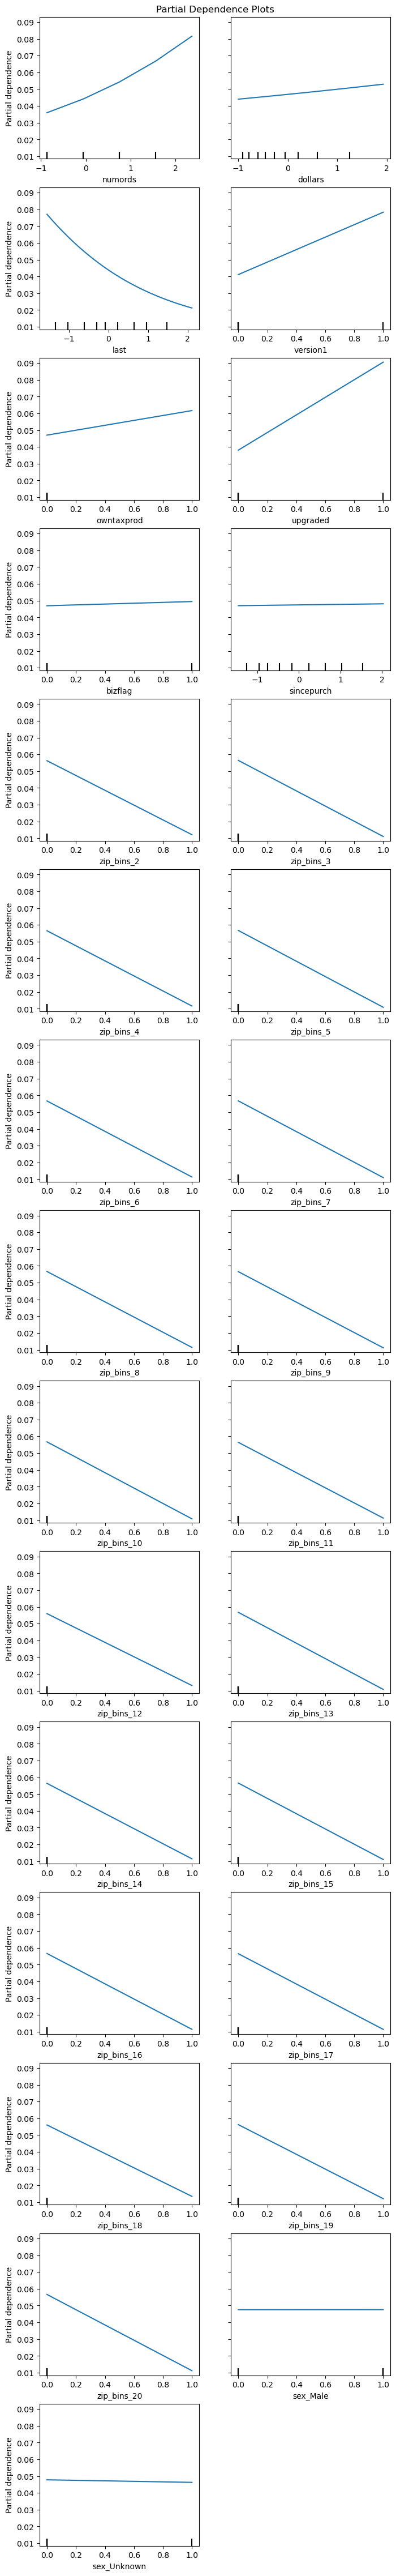

In [68]:
nnr1.plot(plots="pdp")

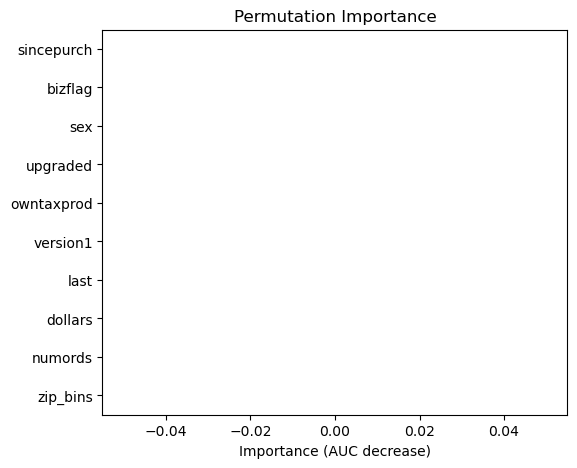

In [69]:
nnr1.plot("vimp")

In [70]:
nnr1.plot("pred")

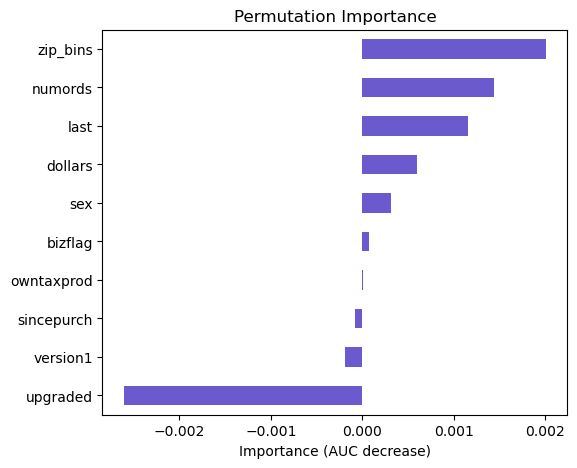

In [71]:
nnr2.plot("vimp")

In [72]:
nnr2.plot("pred")

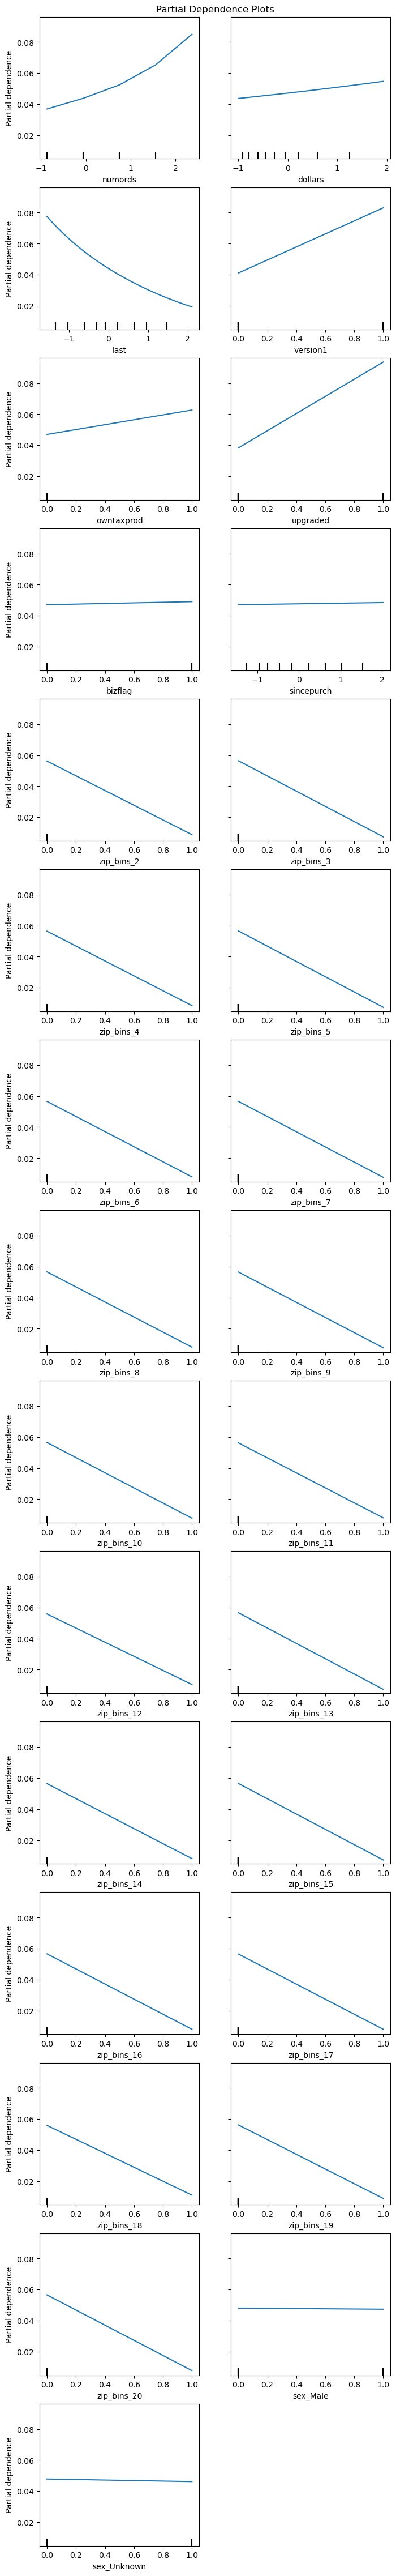

In [73]:
nnr2.plot(plots="pdp")

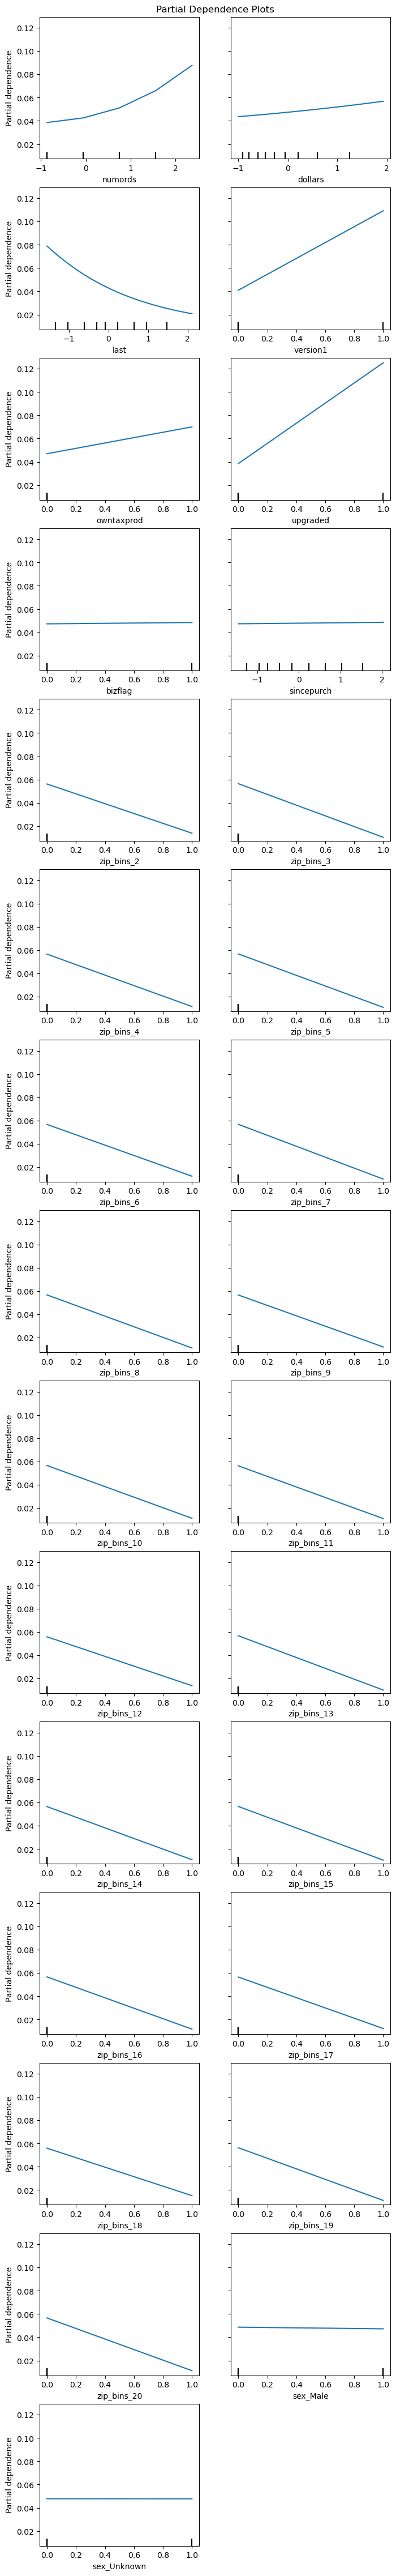

In [74]:
nnr3.plot(plots="pdp")

In [75]:
nnr3.plot("pred")

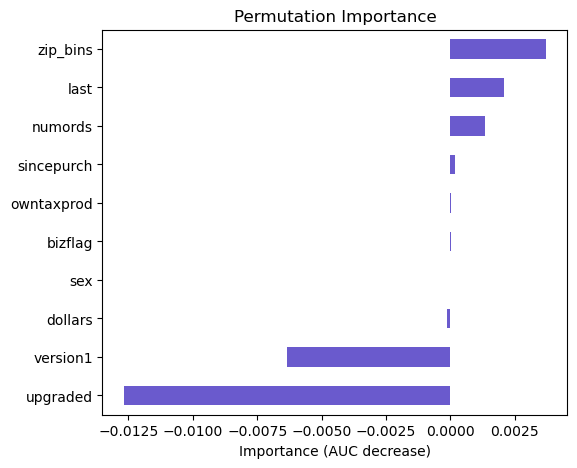

In [76]:
nnr3.plot("vimp")

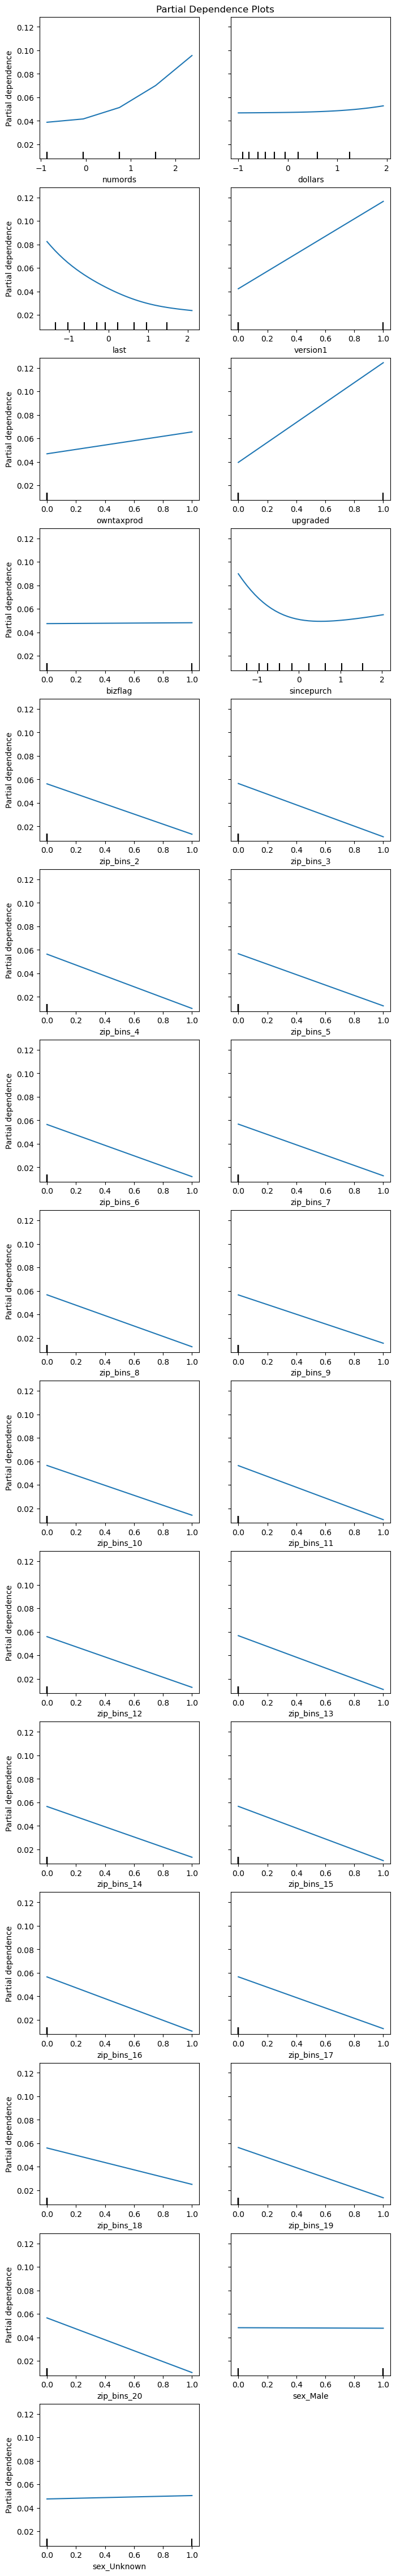

In [77]:
nnr10.plot(plots="pdp")

In [78]:
nnr10.plot("pred")

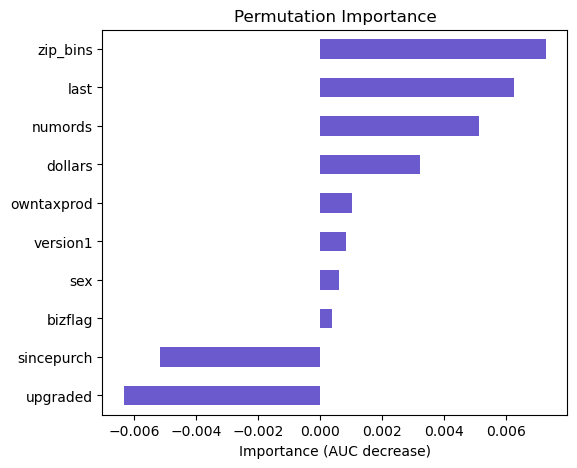

In [79]:
nnr10.plot("vimp")

The Partial Dependence Plots (PDPs) illustrate how individual predictor variables influence the probability of a business responding to the QuickBooks upgrade offer while holding other factors constant. 
Key insights from the plots for nn3 reveal that businesses with more past orders (numords) and higher spending (dollars) are more likely to respond, as indicated by the increasing trends. Similarly, businesses using QuickBooks version 1 (version1), those that own tax-related products (owntaxprod), and those that have previously upgraded (upgraded) exhibit a higher likelihood of responding. In contrast, longer time since last purchase (last) correlates with a decreasing probability of response, suggesting that recent interactions are critical in determining engagement. Additionally, most geographic bins (zip_bins) show a negative trend, implying that businesses in certain locations are less likely to respond. Some variables, such as bclflag, sinexpurch, and sex_Unknown, appear to have minimal impact, as their plots remain flat. Overall, these insights suggest that customer engagement history, purchase behavior, and software version are strong indicators of response probability, which can be leveraged to refine targeting strategies for the campaign.

The prediction graph illustrates how various features influence the model’s estimated probability of a positive response, showing how predicted response likelihood changes as each variable varies while keeping others constant. The nnr3 model suggests that businesses with more past orders (numords), higher spending (dollars), ownership of tax products (owntaxprod), and previous upgrades (upgraded) are more likely to respond positively, as indicated by their increasing trends. In contrast, time since last purchase (last) negatively affects response probability, meaning businesses that have not engaged recently are less likely to respond. Some features, such as bizflag, sincepurch, and sex, show minimal impact, suggesting they do not significantly influence response likelihood. The zip_bins variable exhibits a sharp decline after the first bin, indicating that businesses in a specific geographic category have a much higher predicted probability of response compared to others. Overall, the graph highlights that customer engagement, spending behavior, and past upgrades are the strongest predictors of response, providing valuable insights for optimizing targeted marketing strategies.

The Permutation Importance graph shows the relative impact of different features on the model's predictive performance, measured by the decrease in AUC (Area Under the Curve) when each feature is randomly shuffled. A greater decrease in AUC indicates a more important feature. The most influential variable is zip_bins, suggesting that geographic location significantly affects the likelihood of a response. upgraded and last (time since last purchase) also play crucial roles, indicating that prior upgrades and recent engagement strongly influence response probability. Other key features include numords (number of past orders) and version1 (QuickBooks version 1 users), both of which contribute notably to the model's predictions. In contrast, variables like owntaxprod, dollars, bizflag, sex, and sincepurch have minimal impact, meaning they do not significantly affect response likelihood. Overall, this analysis highlights that geographic location, past upgrades, and recent engagement are the strongest predictors, providing valuable insights for refining targeted marketing strategies.

Checking for fit...

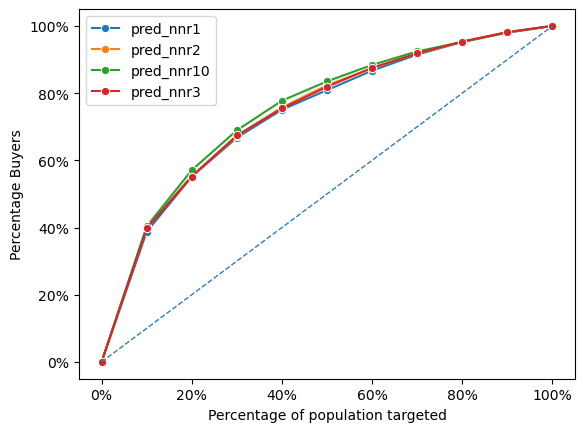

In [80]:
fig = rsm.gains_plot(
    intuit75k, 
    "res1", "Yes",
    [ "pred_nnr1", "pred_nnr2", "pred_nnr10", "pred_nnr3" ],
)

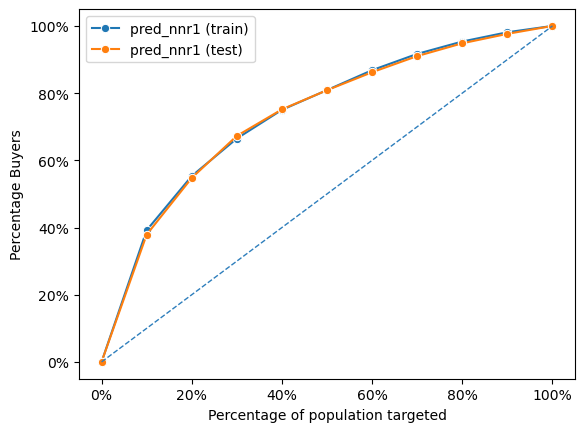

In [81]:
dct = {"train": training_subset ,
       "test": test_subset}
fig = rsm.gains_plot(dct, "res1", "Yes", "pred_nnr1")

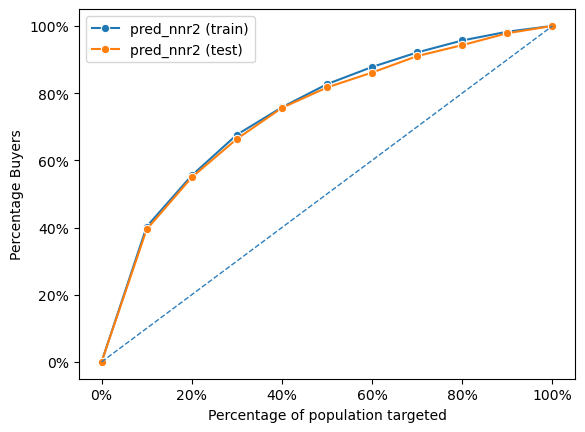

In [82]:
dct = {"train": training_subset ,
       "test": test_subset}
fig = rsm.gains_plot(dct, "res1", "Yes", "pred_nnr2")

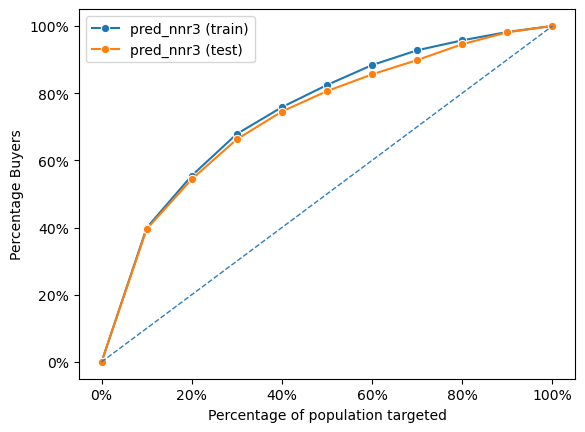

In [83]:
dct = {"train": training_subset ,
       "test": test_subset}
fig = rsm.gains_plot(dct, "res1", "Yes", "pred_nnr3")

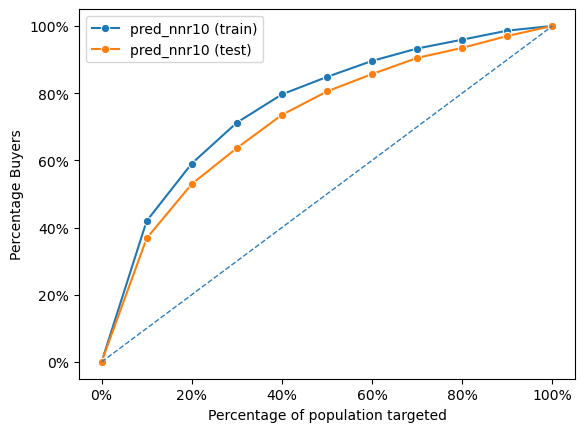

In [84]:
dct = {"train": training_subset ,
       "test": test_subset}
fig = rsm.gains_plot(dct, "res1", "Yes", "pred_nnr10")

The graph represents a Cumulative Gains Chart, comparing the predictive performance of a model on the training dataset (blue line) and the test dataset (orange line). The x-axis represents the percentage of the population targeted, while the y-axis indicates the percentage of actual buyers captured within that segment. The diagonal dashed line represents a random selection baseline, where targeting a given percentage of the population would yield the same percentage of buyers. The fact that both the training and test curves are well above this diagonal confirms that the model is successfully identifying high-response customers more efficiently than random selection. Additionally, the close alignment between the training and test curves suggests that the model generalizes well and does not overfit to the training data. This strong performance indicates that the model is effectively prioritizing high-likelihood buyers, making it a valuable tool for targeted marketing efforts.

#### Model Tuning...

In [85]:
import numpy as np
from sklearn.model_selection import GridSearchCV

hls = [(1,), (2,), (3,), (5, 5), (10, ), (12, )]

param_grid = {"hidden_layer_sizes": hls}
scoring = {"AUC": "roc_auc"}

nnr_cv = GridSearchCV(
    nnr1.fitted, param_grid, scoring=scoring, cv=5, n_jobs=4, refit="AUC", verbose=5
)

In [86]:
nnr1.data_onehot.mean().round(3)
nnr1.data.res1

0        0.0
3        0.0
5        0.0
7        0.0
9        0.0
        ... 
74994    0.0
74995    1.0
74996    0.0
74997    0.0
74998    0.0
Name: res1, Length: 52500, dtype: float64

In [87]:
nnr_cv.fit(nnr1.data_onehot, nnr1.data.res1)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=MLPClassifier(activation='tanh', hidden_layer_sizes=[1],
                                     max_iter=1000000, random_state=1234,
                                     solver='lbfgs'),
             n_jobs=4,
             param_grid={'hidden_layer_sizes': [(1,), (2,), (3,), (5, 5), (10,),
                                                (12,)]},
             refit='AUC', scoring={'AUC': 'roc_auc'}, verbose=5)

In [88]:
nnr1.data_onehot.head()

,numords,dollars,last,version1,owntaxprod,upgraded,bizflag,sincepurch,zip_bins_2,zip_bins_3,...,zip_bins_13,zip_bins_14,zip_bins_15,zip_bins_16,zip_bins_17,zip_bins_18,zip_bins_19,zip_bins_20,sex_Male,sex_Unknown
0,-0.057079,0.207902,-1.137183,0,0,0,0,-0.360809,False,False,...,False,False,False,False,False,True,False,False,True,False
3,-0.863720,-0.873735,0.119783,0,0,0,0,-1.458194,False,False,...,False,False,False,False,False,False,False,False,True,False
5,-0.863720,-0.898458,0.119783,0,0,1,0,0.138003,False,True,...,False,False,False,False,False,False,False,False,True,False
7,-0.863720,-0.842831,-1.241930,1,0,0,1,0.138003,False,False,...,False,False,False,False,False,False,False,False,True,False
9,0.749561,-0.237115,-0.613447,0,0,0,0,-0.660096,False,False,...,False,False,False,False,False,False,False,False,True,False


In [89]:
nnr1.data.res1

0        0.0
3        0.0
5        0.0
7        0.0
9        0.0
        ... 
74994    0.0
74995    1.0
74996    0.0
74997    0.0
74998    0.0
Name: res1, Length: 52500, dtype: float64

In [90]:
pd.DataFrame(nnr_cv.cv_results_).iloc[:, 5:].sort_values("rank_test_AUC")

,params,split0_test_AUC,split1_test_AUC,split2_test_AUC,split3_test_AUC,split4_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC
2,"{'hidden_layer_sizes': (3,)}",0.744194,0.760830,0.758024,0.743183,0.759255,0.753097,0.007740,1
0,"{'hidden_layer_sizes': (1,)}",0.736614,0.754931,0.759844,0.747336,0.763636,0.752472,0.009622,2
1,"{'hidden_layer_sizes': (2,)}",0.733536,0.760789,0.759358,0.743272,0.759661,0.751323,0.010999,3
3,"{'hidden_layer_sizes': (5, 5)}",0.708417,0.734974,0.748314,0.725403,0.740030,0.731428,0.013693,4
4,"{'hidden_layer_sizes': (10,)}",0.723893,0.731569,0.741355,0.712707,0.724207,0.726746,0.009470,5
5,"{'hidden_layer_sizes': (12,)}",0.697759,0.737966,0.735913,0.723667,0.724825,0.724026,0.014327,6


In [91]:
nnr_cv.best_params_

{'hidden_layer_sizes': (3,)}

In [92]:
nnr_cv.best_score_.round(3)

0.753

In [93]:
# prediction on training set
from sklearn import metrics
pred = intuit75k.loc[intuit75k.training == 1, "pred_nnr3"]
actual = rsm.ifelse(intuit75k.loc[intuit75k.training == 1, "res1"] == "Yes", 1, 0)
fpr, tpr, thresholds = metrics.roc_curve(actual, pred)
metrics.auc(fpr, tpr).round(3)

0.766

In [94]:
actual = intuit75k.loc[intuit75k.training == 1, "res1"]
rsm.auc(actual, pred, "Yes").round(3)

0.766

In [95]:
# prediction on test set
pred = intuit75k.loc[intuit75k.training == 0, "pred_nnr3"]
actual = rsm.ifelse(intuit75k.loc[intuit75k.training == 0, "res1"] == "Yes", 1, 0)
fpr, tpr, thresholds = metrics.roc_curve(actual, pred)
metrics.auc(fpr, tpr).round(3)

0.752

In [96]:
# prediction on test set
actual = intuit75k.loc[intuit75k.training == 0, "res1"]
rsm.auc(actual, pred, "Yes").round(3)

0.752

So, it is clear by the model tuning step that the Neural Network Model with 3 nodes and 1 layer, which is, [3,], has the best AUC ranking, and we go ahead with it and test with the logistic model.

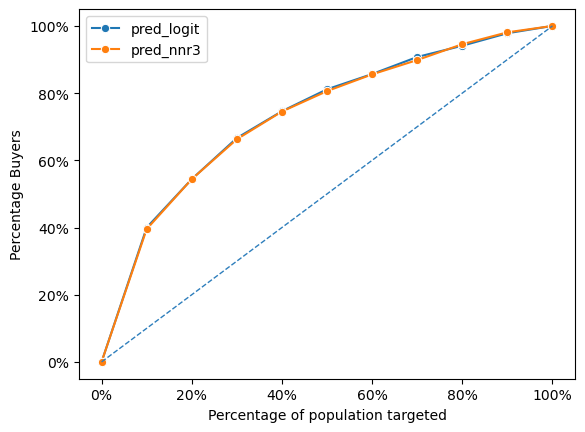

In [97]:
fig = rsm.gains_plot(intuit75k[intuit75k.training == 0], "res1", "Yes", ["pred_logit","pred_nnr3"])

The Cumulative Gains Chart shows that both models, pred_logit (blue) and pred_nnr3 (orange), effectively rank customers based on their likelihood to purchase, as both curves are well above the random selection baseline. However, pred_logit demonstrates a slight advantage, capturing a marginally higher proportion of buyers at various points, particularly in the middle range of the population (30%-80% targeted). This suggests that pred_logit is slightly more effective at prioritizing high-response customers. Toward the upper end (90%-100% targeted), both models converge, indicating that they ultimately capture nearly the same total number of buyers. While the difference is minimal, pred_logit may be the better choice for optimizing marketing efforts.

In [98]:
#prediction variable for wave 1
intuit75k["mail_wave1_nn"] = intuit75k.pred_nnr3 > breakeven

# Predictions for wave 2 (50% of probability of wave 1)
intuit75k["mail_wave2_nn"] = intuit75k.pred_nnr3 * 0.5 > breakeven

intuit75k.head()

,id,zip5,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,...,pred_logit_wave2,pred_logit_dec,mail_wave1,mail_wave2,pred_nnr1,pred_nnr2,pred_nnr10,pred_nnr3,mail_wave1_nn,mail_wave2_nn
0,1,94553,18,Male,0,2,109.5,5,12,0,...,0.019908,4,True,False,0.040269,0.040674,0.027965,0.043903,True,False
1,2,53190,10,Unknown,0,1,69.5,4,3,0,...,0.016265,5,True,False,0.020036,0.027513,0.026704,0.028420,True,False
2,3,37091,8,Male,0,4,93.0,14,29,0,...,0.038366,2,True,True,0.096701,0.071984,0.131371,0.074607,True,True
3,4,02125,1,Male,0,1,22.0,17,1,0,...,0.080123,1,True,True,0.131114,0.141847,0.160992,0.141647,True,True
4,5,60201,11,Male,0,1,24.5,2,3,0,...,0.012443,6,True,False,0.023586,0.026844,0.033358,0.024084,True,False


In [99]:
cost_per_mail = 1.41
revenue_per_response = 60
test_subset['mail_wave1'] = intuit75k['mail_wave1_nn'] 
mail_per = test_subset['mail_wave1'].mean()
mail_data = test_subset[test_subset['mail_wave1']]
num_mail = mail_data.shape[0]
response_rate = (mail_data['res1'] == 'Yes').mean()
num_responses = (mail_data['res1'] == 'Yes').sum()
total_revenue = num_responses * revenue_per_response
total_mail_cost = num_mail * cost_per_mail
profit = total_revenue - total_mail_cost
ROME = profit / total_mail_cost
    
output = f"""
- Intuit should focus on reaching out to approximately {(num_mail):,.0f} customers, which represents {100 * mail_per:.2f}% of the total.
- The anticipated response rate for these selected customers is {100 * response_rate:.2f}%, translating to around {num_responses:,.0f} responses.
- The projected revenue from this campaign is estimated at ${total_revenue:,.2f}.
- The expected profit stands at ${profit:,.2f}.
- The total cost of mailing is estimated at ${total_mail_cost:,.2f}, with a Return on Marketing Effort (ROME) of {100 * ROME:.2f}%.
"""
        
print(output)
    
print(response_rate, mail_per)


- Intuit should focus on reaching out to approximately 13,361 customers, which represents 59.38% of the total.
- The anticipated response rate for these selected customers is 7.06%, translating to around 943 responses.
- The projected revenue from this campaign is estimated at $56,580.00.
- The expected profit stands at $37,740.99.
- The total cost of mailing is estimated at $18,839.01, with a Return on Marketing Effort (ROME) of 200.33%.

0.07057854950976723 0.5938222222222223


/tmp/ipykernel_96028/771626213.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_subset['mail_wave1'] = intuit75k['mail_wave1_nn']


In [100]:
test_subset['mail_wave2'] = intuit75k['mail_wave2_nn'] 

/tmp/ipykernel_96028/2133648343.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_subset['mail_wave2'] = intuit75k['mail_wave2_nn']


In [101]:
cost_per_mail = 1.41
revenue_per_response = 60
mail_per = test_subset['mail_wave2'].mean()
mail_data = test_subset[test_subset['mail_wave2']]
num_mail = mail_data.shape[0]
num_responses = num_mail * response_rate
total_revenue = num_responses * revenue_per_response
total_mail_cost = num_mail * cost_per_mail
profit = total_revenue - total_mail_cost
ROME = profit / total_mail_cost
    
output = f"""
- Intuit should focus on reaching out to approximately {(num_mail):,.0f} customers, which represents {100 * mail_per:.2f}% of the total.
- The anticipated response rate for these selected customers is {100 * response_rate:.2f}%, translating to around {num_responses:,.0f} responses.
- The projected revenue from this campaign is estimated at ${total_revenue:,.2f}.
- The expected profit stands at ${profit:,.2f}.
- The total cost of mailing is estimated at ${total_mail_cost:,.2f}, with a Return on Marketing Effort (ROME) of {100 * ROME:.2f}%.
"""
        
print(output)
print(response_rate, mail_per)


- Intuit should focus on reaching out to approximately 6,810 customers, which represents 30.27% of the total.
- The anticipated response rate for these selected customers is 7.06%, translating to around 481 responses.
- The projected revenue from this campaign is estimated at $28,838.40.
- The expected profit stands at $19,236.30.
- The total cost of mailing is estimated at $9,602.10, with a Return on Marketing Effort (ROME) of 200.33%.

0.07057854950976723 0.30266666666666664


In [102]:
intuit75k.head()

,id,zip5,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,...,pred_logit_wave2,pred_logit_dec,mail_wave1,mail_wave2,pred_nnr1,pred_nnr2,pred_nnr10,pred_nnr3,mail_wave1_nn,mail_wave2_nn
0,1,94553,18,Male,0,2,109.5,5,12,0,...,0.019908,4,True,False,0.040269,0.040674,0.027965,0.043903,True,False
1,2,53190,10,Unknown,0,1,69.5,4,3,0,...,0.016265,5,True,False,0.020036,0.027513,0.026704,0.028420,True,False
2,3,37091,8,Male,0,4,93.0,14,29,0,...,0.038366,2,True,True,0.096701,0.071984,0.131371,0.074607,True,True
3,4,02125,1,Male,0,1,22.0,17,1,0,...,0.080123,1,True,True,0.131114,0.141847,0.160992,0.141647,True,True
4,5,60201,11,Male,0,1,24.5,2,3,0,...,0.012443,6,True,False,0.023586,0.026844,0.033358,0.024084,True,False


Extracting results for Logitics Regression Model...

In [106]:
# DataFrame with the id's of the target customers
mail_id = intuit75k[intuit75k.training == 0][["id", "mail_wave2"]].rename(columns={"mail_wave2": "mailto_wave2"})
mail_id.to_csv("Group39_Intuit.csv", index=False)